The following code has been manually translated from Spanish to English. Due to execution times, code subject to dependencies that take a long time to execute, mainly graphics, are still in the original language.

Authors:
- Alcalde Benítez, Patricia
- Vulpe, Beatriz Noelia

In this section a time series prediction problem will be solved. It is about birth values by province, sex (value 1 means Male, 6 Female) and date for all months between 2016 and 2021.

- We will train and preprocess the data, as well as perform data analysis.

- Second, we will train models and evaluate them with visualizations and the MAE metric for the year 2021 based on the above data.

- Third, we will predict the values for 2022.

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
import seaborn as sns

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
df= pd.read_csv('nacimientos_2016_2021.csv')

In [4]:
df.head()

,PROI,SEXO,MESPAR,ANOPAR,count
0,1,1,1,2021,98
1,1,1,2,2021,92
2,1,1,3,2021,108
3,1,1,4,2021,99
4,1,1,5,2021,90


# **1. Description of the dataset**

Our dataset has a total of 5 columns: `PROI SEX MESPAR ANOPAR count`. As a first step, we will analyze the nature of the data and presence of missing data, to decide if they need any processing.

In [5]:
column_info = pd.DataFrame({
    'Data Type': df.dtypes,
    'Distinct Values': df.nunique(),
    'Missing Values': df.isnull().sum()
})
column_info

,Data Type,Distinct Values,Missing Values
PROI,int64,52,0
SEXO,int64,2,0
MESPAR,int64,12,0
ANOPAR,int64,6,0
count,int64,1041,0


We have a complete DataFrame, **without** the presence of **missing values**. All columns in the dataset contain integer values, as they are expected to be within the range allowed by the int64 data type. Therefore, we **don't** have **non-numeric** or **non-representative** **values** of the contents of each column. We have a total of:
- 52 provinces
- 2 representative values for gender
- 12 months
- 6 years

These findings provide a solid basis for further analysis, highlighting the diversity and consistency of the data collected.



---



Let's see what information their statistics provide us with.

In [6]:
df.describe()

,PROI,SEXO,MESPAR,ANOPAR,count
count,7488.000000,7488.000000,7488.000000,7488.000000,7488.00000
mean,26.500000,3.500000,6.500000,2018.500000,295.92054
std,15.009333,2.500167,3.452283,1.707939,420.07736
min,1.000000,1.000000,1.000000,2016.000000,14.00000
25%,13.750000,1.000000,3.750000,2017.000000,83.00000
50%,26.500000,3.500000,6.500000,2018.500000,191.00000
75%,39.250000,6.000000,9.250000,2020.000000,306.00000
max,52.000000,6.000000,12.000000,2021.000000,2902.00000


The dataset covers the period from **2016** to **2021** and includes detailed information on **7,488 births**.

- The distribution of provinces exhibits remarkable equity, with an average and median of 26.5, suggesting a **balanced** representation** of data for each **province** under study.

- Regarding **sex** of newborns, the 'SEX' column uses **numeric coding**, where 1 indicates Male and 6 indicates Female.

- The statistics highlight an even distribution of births throughout the year, evidenced by a mean and median month of delivery (MESPAR) set at 6.5. However, **birth counts exhibit significant variability**, with a minimum of 14 and a maximum of 2,902, underscoring the breadth of birth frequency recorded.




---



Next, we will explore additional aspects to gain a more complete and meaningful understanding of the data. These steps will allow us to explore more thoroughly and facilitate the identification of key demographic patterns in the dataset.

We will use the temporal information provided by the `MESPAR ANOPAR` columns: we will create a new `date` column.

In [7]:
df['fecha'] = pd.to_datetime(df['ANOPAR'].astype(str) + '-' + df['MESPAR'].astype(str), format='%Y-%m')
df.sort_values(by='fecha')
df.head()

,PROI,SEXO,MESPAR,ANOPAR,count,fecha
0,1,1,1,2021,98,2021-01-01
1,1,1,2,2021,92,2021-02-01
2,1,1,3,2021,108,2021-03-01
3,1,1,4,2021,99,2021-04-01
4,1,1,5,2021,90,2021-05-01


We will visually represent the number of births over the years along with their separation by color of characteristics, which will allow us to easily identify the contribution of each one of them. **Are there notable differences in birth trends?**

**Province influence**


---



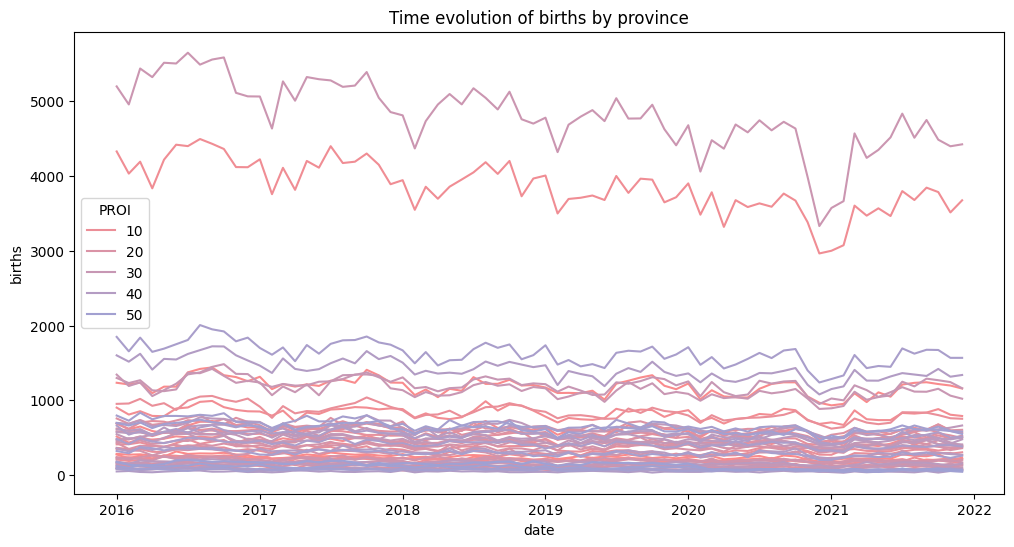

In [8]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='fecha', y='count', data= df.groupby(['fecha', 'PROI'])['count'].sum().reset_index(), hue='PROI', palette=("blend:#FD8A8A,#9EA1D4"))
plt.title('Time evolution of births by province')
plt.xlabel('date')
plt.ylabel('births')
plt.show()

**Sex variable Influence**


---



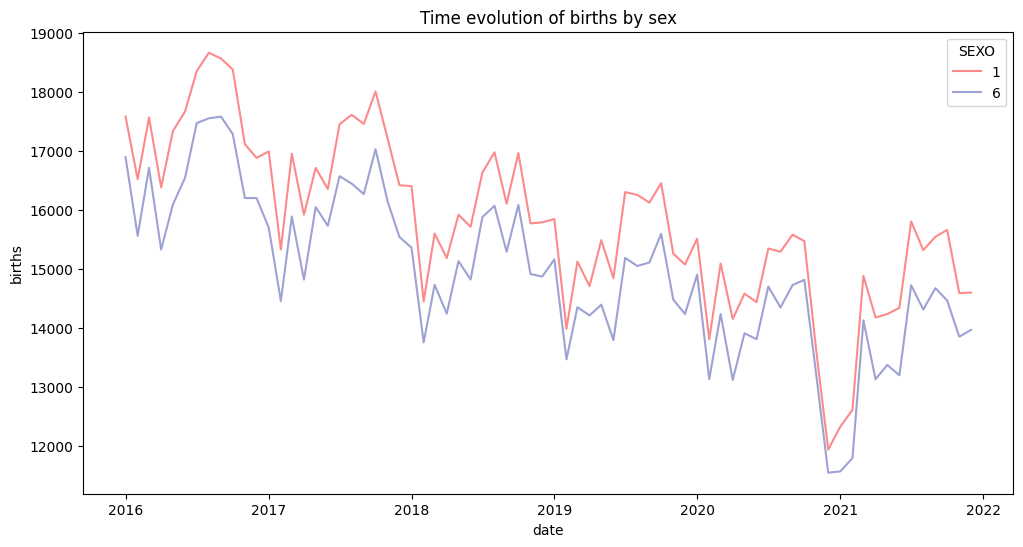

In [9]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='fecha', y='count', data= df.groupby(['fecha', 'SEXO'])['count'].sum().reset_index(), hue='SEXO', palette=("blend:#FD8A8A,#9EA1D4"))
plt.title('Time evolution of births by sex')
plt.xlabel('date')
plt.ylabel('births')
plt.show()

It is evident that **distinctions** by sex or province **do not exert significant influence** on the **characteristics of the time series**. In all cases, the evolution shows a similar shape and trend over time, indicating that the separation does not modify the time structure of the series. The only observable variation lies in the total number of births.

In other words, the distinction between sexes or provinces does not alter the shape of the time wave, suggesting that the **temporal study can be carried out without this division**, since it does not bring about substantial changes in the overall dynamics of the series.

In [10]:
# We group by the column "date" and add the column "count".
# We thus obtain the total number of births by date (month-year).
X_full = df.groupby('fecha')['count'].sum().reset_index()

#**2. Time series analysis**

We change the index of `X_full` to facilitate the visualization according to the years:

In [11]:
X_visualizacion = X_full.set_index('fecha')

In [12]:
def plot_series(series):
    plt.figure(figsize=(12,6))
    plt.plot(series, color='#9EA1D4')
    plt.ylabel('# of births', fontsize=16)

    for year in range(2016, 2023):
        plt.axvline(datetime(year,1,1), linestyle='--', color='#9EA1D4', alpha=0.5)

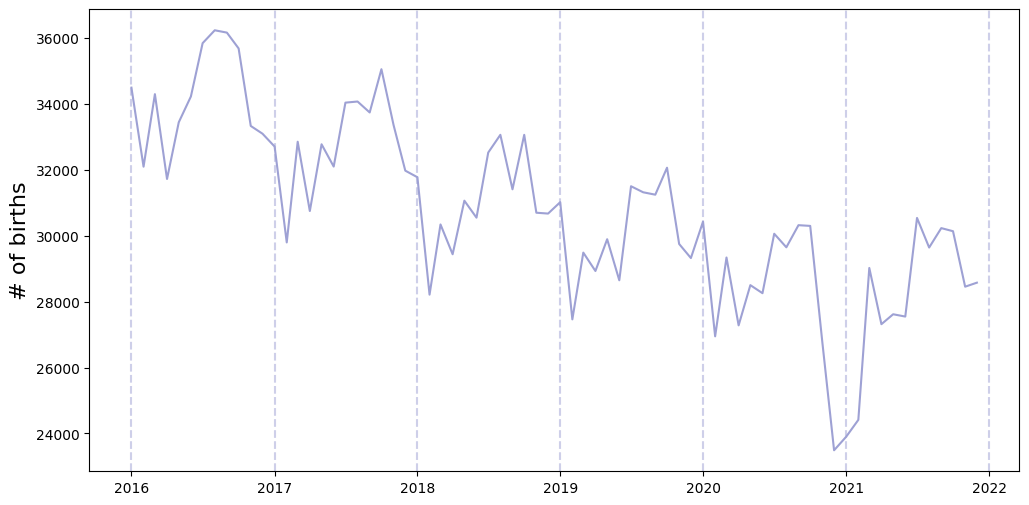

In [13]:
plot_series(X_visualizacion)


**1.** We can observe possible seasonality. Seasonality refers to recurring or cyclical patterns in a time series that occur at regular intervals, such as daily, monthly or annual patterns. Having the beginning of each year marked, a certain 'boom' in births recurs around the middle of the year, arguably especially in the late summer months.

**2.** In addition, we have a decreasing trend.




---



Visualization of the temporal evolution:

In [14]:
months = []
for m in range(12):
    months.append(X_visualizacion.iloc[m::12])

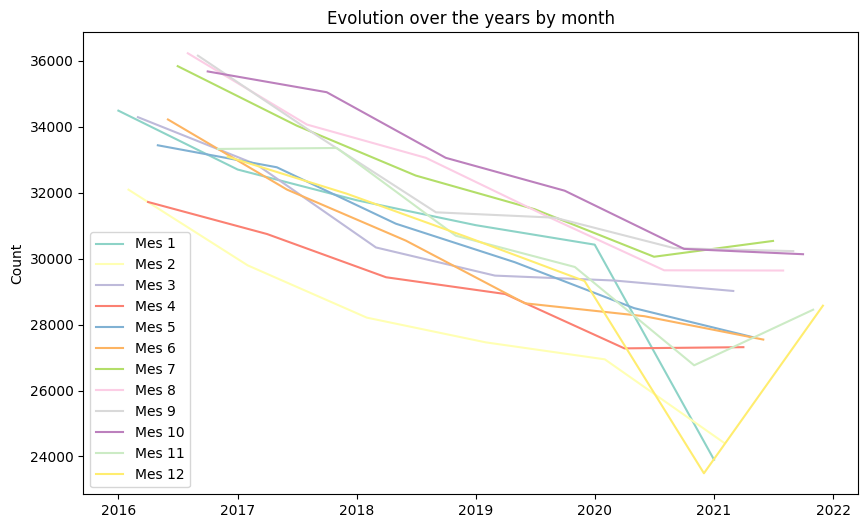

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

colores = plt.get_cmap('Set3', 12)

for m in range(12):
    plt.plot(months[m]['count'], label=f'Mes {m + 1}', color=colores(m))

plt.ylabel('Count')
plt.title('Evolution over the years by month')
plt.legend()
plt.show()

* As the months in a year progress, the number of births increases.
* Analyzing the same progress over the years, the overall number of births decreases.




---



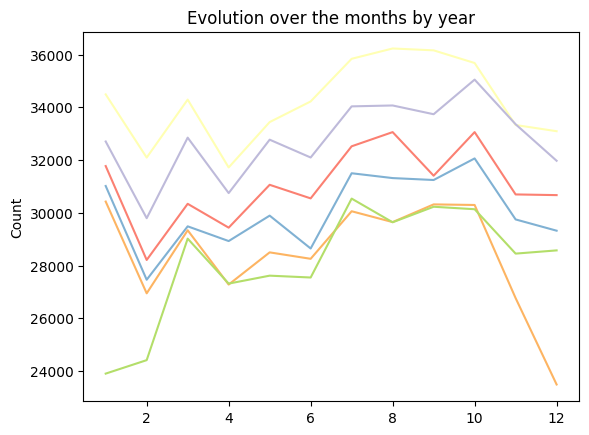

In [16]:
c = 1
for i in range(0,df.shape[0],12):
    if df.shape[0]-i >=12:
        plt.plot(X_visualizacion.iloc[i:i + 12].index.month,X_visualizacion.iloc[i:i+12]['count'],color=colores(c))
        c += 1

plt.ylabel('Count')
plt.title('Evolution over the months by year')
plt.show()

A local maximum can be seen in the late summer months.

## **2.1. Decomposition: Seasonality and Trend.**

A time series can possess certain characteristics that make it difficult to understand and predict a time series. Therefore, it is important to be able to decompose the time series into its "atomic components". A common decomposition is to write the time series as

$$
X(t) = T(t) + S(t) + R(t).
$$

Here $T(t)$ is the so-called **trend**, the natural evolution of the time series regardless of seasonality, $S(t)$ is the **seasonal component** due to periodic changes and $R(t)$ is the **remaining component**. We will use `seasonal_decompose` from `statsmodels`.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(X_visualizacion, model='additive', period = 12)

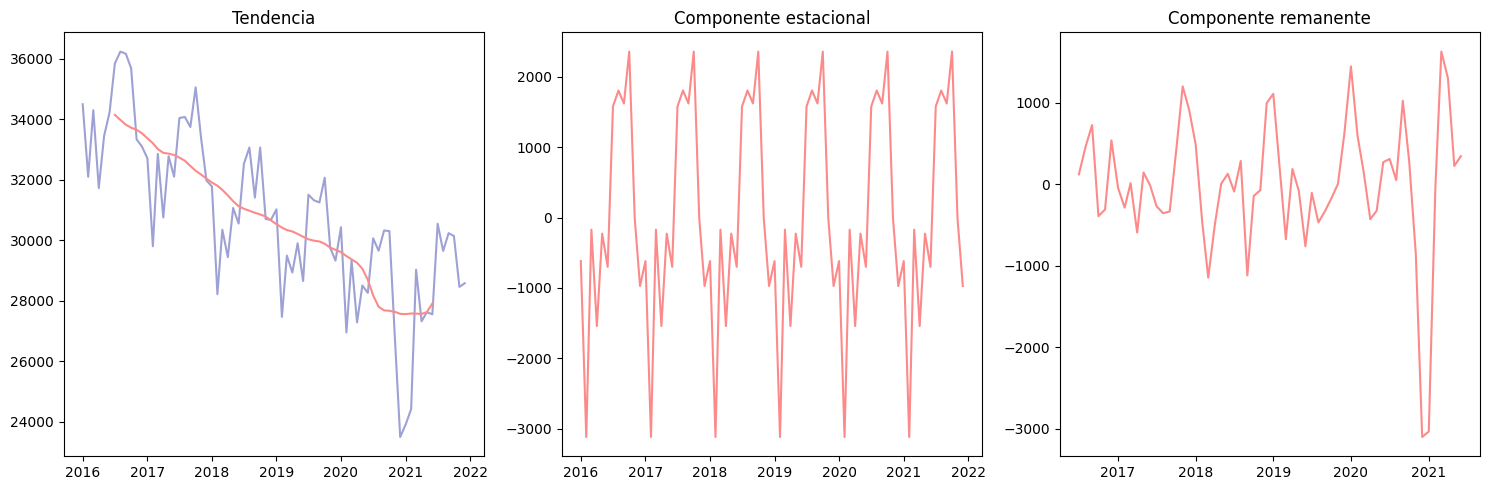

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# trend
axs[0].plot(X_visualizacion, color='#9EA1D4')
axs[0].plot(result.trend, color='#FD8A8A')
axs[0].set_title('Tendencia')

# seasonal component
axs[1].plot(result.seasonal, color='#FD8A8A')
axs[1].set_title('Componente estacional')

# remaining component
axs[2].plot(result.resid, color='#FD8A8A')
axs[2].set_title('Componente remanente')


plt.tight_layout()


plt.show()

With this decomposition analysis we can confirm the **declining trend** and **seasonality** of this time series.

## **2.2. Autocorrelation: Stationarity**

A stationary time series has constant statistical properties over time. This will be represented as highly correlated peaks in the autocorrelation plot.

Stationarity facilitates modeling and analysis of time series, since many statistical methods and models assume that the series is stationary.

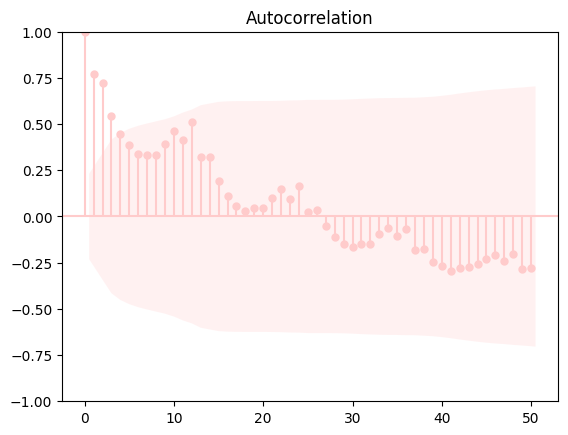

In [ ]:
# The shaded region corresponds to the 0.95 confidence interval around the correlation.

from statsmodels.graphics.tsaplots import plot_acf

plot_acf(X_visualizacion, lags = 50)
plt.show()

The **ADF** (Augmented Dickey-Fuller) test is a statistical test used to assess whether a time series has a unit root, which implies non-stationarity. The p-value of the ADF test is essential for making decisions on whether or not to reject the null hypothesis of the presence of a unit root.

* **Null hypothesis (H0):** The time series has a unit root, it is non-stationary.
* **Alternative hypothesis (H1):** The time series does not have a unit root, it is stationary.

The p-value obtained from the ADF test is compared with a significance threshold (alpha level, commonly 0.05). If the p-value is less than the alpha level, the null hypothesis is rejected and it is concluded that the time series is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(X_visualizacion)
print(f'p-value: {adf_test[1]}')

p-value: 0.5832803625469123


With such a p-value the hypothesis cannot be rejected: we cannot state that the series is stationary, so we suppose that a possible treatment of non-stationarity could improve some results.

In [ ]:
adf_test = adfuller(X_visualizacion.diff().dropna())
print(f'p-value: {adf_test[1]}')

p-value: 0.14919030071078548


In [ ]:
adf_test = adfuller(X_visualizacion.diff().diff().dropna())
print(f'p-value: {adf_test[1]}')

p-value: 2.474017344117093e-13




---



Let us also use the **Kwiatkowski-Phillips-Schmidt-Shin (KPSS)** test to verify our hypothesis. This is a statistical test used to assess whether a time series is stationary around a deterministic trend. The test has two null hypotheses (H0) and two alternative hypotheses (H1):

- **Null Hypothesis Stationary (H0)**: The time series is stationary around a deterministic trend.

- **Non-Stationary Alternative Hypothesis (H1)**: The time series is not stationary.

In [ ]:
from statsmodels.tsa.stattools import kpss


result = kpss(X_visualizacion)

test_statistic = result[0]
p_value = result[1]
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")

Test Statistic: 1.0185231814581748
P-value: 0.01


If the test statistic is large or the p-value is small (usually less than 0.05), we have evidence to reject the null hypothesis and conclude that the series is not stationary. In our case, with a p-value less than **0.01**, we can conclude that the series **is not stationary**.

# **3. Year 2021 forecast**

Before training our models, we have to divide the data into training and testing:

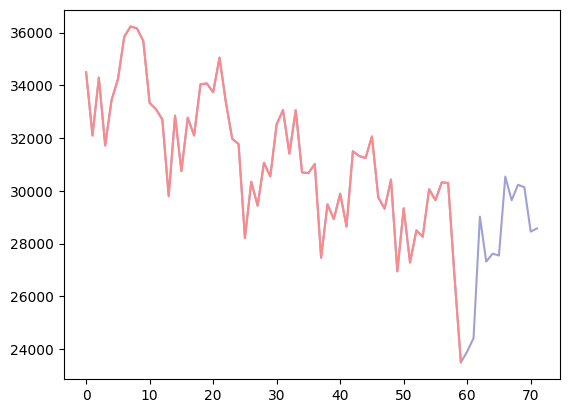

In [ ]:
last_time = X_full[X_full['fecha'].dt.year < 2021].index[-1] +1 # index of the last sample of the year 2020
X_full = X_full['count']
X = X_full[0:last_time]
T_missing = range(last_time, X_full.shape[0])

plt.plot(X_full, color='#9EA1D4')
plt.plot(X, color='#FD8A8A')
plt.show()

In [ ]:
MAE = [] # Create list to compare MAE metrics of the models

In [ ]:
np.random.seed(1) # we establish a seed in order to ensure reproducibility, effective code debugging and reliable comparison between models

## **3.1. Naïve forecasting**


A very simple approach to the problem of predicting the next value of a discrete time series is to use the previous value as the predicted value. In other words:

$$
    \hat{X}(t) = X(t-1).
$$
Obviously, this approach has several shortcomings.

* it **does not** use **any** knowledge about the previous values of the time series, only the last value, ignoring a lot of information.
* this method **only allows for very short-term forecasting**: only the next value in the time series can be predicted. For all other future values the immediately previous value is not known, so the prediction must be used and therefore a constant prediction is returned.

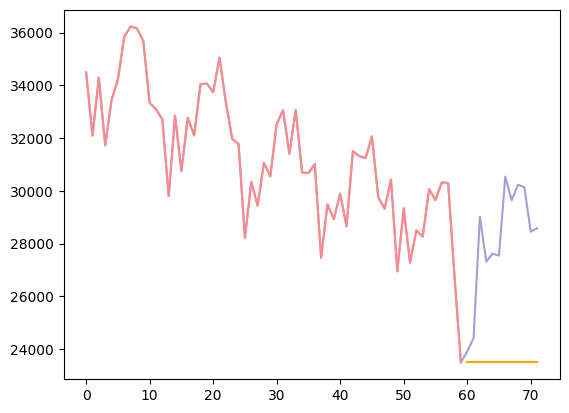

In [ ]:
def X_hat(X, t):
    return X.iloc[-1]

X_hat_series = np.array([X_hat(X, t) for t in T_missing])

plt.plot(X_full, color='#9EA1D4')
plt.plot(X, color='#FD8A8A')
plt.plot(T_missing, X_hat_series, color='orange')
plt.show()

In [ ]:
print(mean_absolute_error(X_full[T_missing], X_hat_series))

4625.0


In [ ]:
MAE.append(mean_absolute_error(X_full[T_missing], X_hat_series))



---



The resulting error is obviously very high. We can also 'roll-up' the result, trying to predict only the next value:

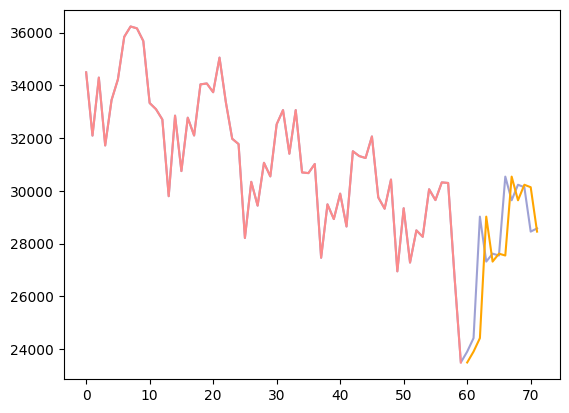

In [ ]:
def X_hat(X, t):
    return X[t-1]

X_hat_series = np.array([X_hat(X_full, t) for t in T_missing])

plt.plot(X_full, color='#9EA1D4')
plt.plot(X, color='#FD8A8A')
plt.plot(T_missing, X_hat_series, color='orange')
plt.show()

In [ ]:
print(mean_absolute_error(X_full[T_missing], X_hat_series))

1165.3333333333333


In [ ]:
MAE.append(mean_absolute_error(X_full[T_missing], X_hat_series))

## **3.2. Simple regression, ignoring the time component**


Another naïve approach to tackle the time series prediction problem is to completely forget the time component of the series and treat it as a simple regression problem.

To do this, we set a window with $W > 0$ and create the data set for training by collecting the $W$ previous data as follows:
$$
    \mathit{X}^{train} = \left\{\left(X(0), X(1), \ldots, X(W-1)\right), \left(X(1), X(2), \ldots, X(W)\right), \ldots, \left(X(N-W-1), X(1), \ldots, X(N-2)\right)\right\}
$$
$$
    \mathit{Y}^{train} = \left\{X(W), X(W+1), \ldots, X(N-1)\right\}
$$

With this data set, we train a standard ML regressor $f: \mathbb{R}^W \to \mathbb{R}$ and use it to predict future values as:

$$
    \hat{X}(t) = f\left(X(t-W), X(t-W+1), \ldots, X(t-1)\right)
$$

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.utils import shuffle

W = 20
N = X.shape[0]
Xtrain = np.matrix([[X[i + h] for h in range(W)] for i in range(N-W-1)])
Ytrain = np.array([X[i] for i in range(W, N-1)])

Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
Xtrain = np.asarray(Xtrain)
Ytrain = np.asarray(Ytrain)

### **3.2.1. Tree Regressor**

In [ ]:
reg = tree.DecisionTreeRegressor() # Decission tree

reg.fit(Xtrain, Ytrain)

def X_hat(X, t):
    return reg.predict([np.array([X[t-W+h] for h in range(W)])])

X_hat_series = X.to_numpy()
for t in T_missing:
    X_hat_series = np.hstack((X_hat_series, X_hat(X_hat_series, t)))

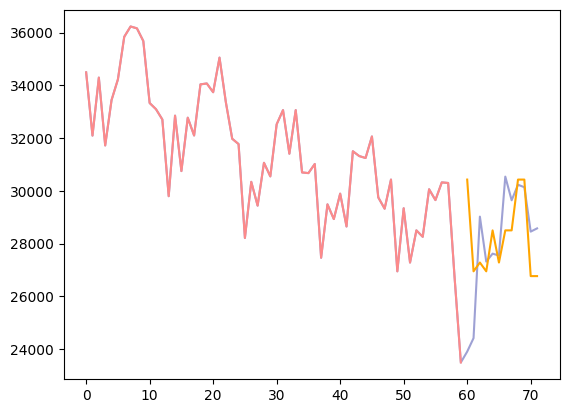

In [ ]:
plt.plot(X_full, color='#9EA1D4')
plt.plot(X, color='#FD8A8A')
plt.plot(T_missing, X_hat_series[T_missing], color='orange')
plt.show()

In [ ]:
print(mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))

1623.1666666666667


In [ ]:
MAE.append(mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))

### **3.2.2. Linear Regression**



In [ ]:
reg = LinearRegression()

reg.fit(Xtrain, Ytrain)

def X_hat(X, t):
    return reg.predict([np.array([X[t-W+h] for h in range(W)])])

X_hat_series = X.to_numpy()
for t in T_missing:
    X_hat_series = np.hstack((X_hat_series, X_hat(X_hat_series, t)))

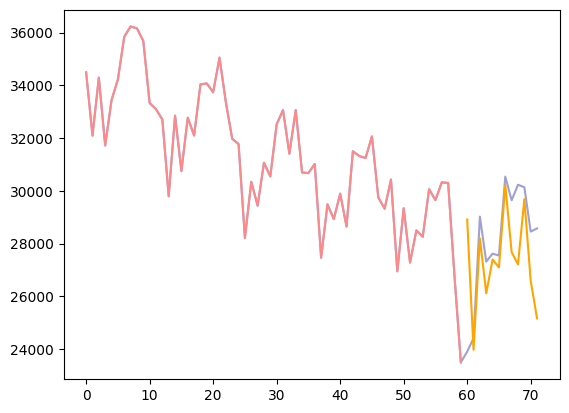

In [ ]:
plt.plot(X_full, color='#9EA1D4')
plt.plot(X, color='#FD8A8A')
plt.plot(T_missing, X_hat_series[T_missing], color='orange')
plt.show()

In [ ]:
print(mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))

1599.2821559416986


In [ ]:
MAE.append(mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))

### **3.2.3.Predicting only the following value (roll-up)**

**Tree Regressor**


---



In [ ]:
reg = tree.DecisionTreeRegressor()

reg.fit(Xtrain, Ytrain)

def X_hat(X, t):
    return reg.predict([np.array([X[t-W+h] for h in range(W)])])

X_hat_series = np.array([])
for t in T_missing:
    X_hat_series = np.hstack((X_hat_series, X_hat(X_full, t)))

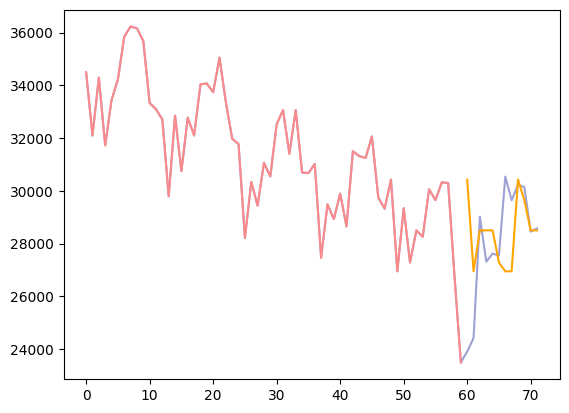

In [ ]:
plt.plot(X_full, color='#9EA1D4')
plt.plot(X, color='#FD8A8A')
plt.plot(T_missing, X_hat_series, color='orange')
plt.show()

In [ ]:
print(mean_absolute_error(X_full[T_missing], X_hat_series))

1583.5833333333333


In [ ]:
MAE.append(mean_absolute_error(X_full[T_missing], X_hat_series))

**Linear Regression**


---



In [ ]:
reg = LinearRegression()

reg.fit(Xtrain, Ytrain)

def X_hat(X, t):
    return reg.predict([np.array([X[t-W+h] for h in range(W)])])

X_hat_series = np.array([])
for t in T_missing:
    X_hat_series = np.hstack((X_hat_series, X_hat(X_full, t)))

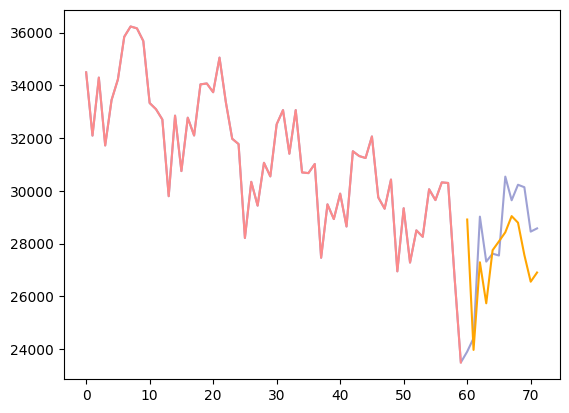

In [ ]:
plt.plot(X_full, color='#9EA1D4')
plt.plot(X, color='#FD8A8A')
plt.plot(T_missing, X_hat_series, color='orange')
plt.show()

In [ ]:
print(mean_absolute_error(X_full[T_missing], X_hat_series))

1643.8539350653539


In [ ]:
MAE.append(mean_absolute_error(X_full[T_missing], X_hat_series))

## **3.3. Exponential smoothing**

The idea of this method is to take advantage of the naïve forecasting idea. However, now, unlike the naïve approach, we will not only look at the last known value of the time series, but also at some of the previous values, calculating a weighted average.

Suppose we want to predict $X(t)$ for some value $t > 0$ and the values $X(t')$ for $t'<t$ are known. Let us set a width $W > 1$ and a real parameter $0 < \alpha < 1$. We recursively set
$$
    s_i = \alpha X(t-W+i) + (1-\alpha)s_{i-1}, \quad s_{-1} = 0
$$

After calculating this sequence, we set $\hat{X}(t) = s_{W-1}$. The rationale for this choice is that, if we extend the recursive formula above, we find that

\begin{align*}
    \hat{X}(t) = s_{W-1} &= \alpha X(t-1) + (1-\alpha)s_{W-2} = \alpha X(t-1) + (1-\alpha)\left(\alpha X(t-2) + (1-\alpha)s_{W-3}\right) \\
    &= \alpha X(t-1) + \alpha(1-\alpha)X(t-2) + (1-\alpha)^2s_{W-3} = \ldots \\
    & = \alpha X(t-1) + \alpha(1-\alpha)X(t-2) + \alpha (1-\alpha)^2X(t-3) + \ldots + \alpha(1-\alpha)^{W-1}X(t-W) + (1-\alpha)^{W}s_{-1} \\
    &= \alpha X(t-1) + \alpha(1-\alpha)X(t-2) + \alpha (1-\alpha)^2X(t-3) + \ldots + \alpha(1-\alpha)^{W-1}X(t-W).
\end{align*}

In this sense, exponential smoothing is a weighted moving average, in which each of the terms loses importance over time.

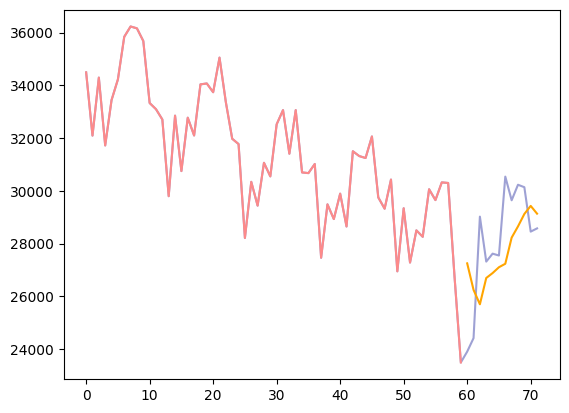

In [ ]:
W = 20
alpha = 0.3

def X_hat(X, t, W, alpha):
    s = X[t-W]
    for h in range(W):
        s = alpha*X[t-W+h] + (1-alpha)*s
    return s

X_hat_series = np.array([X_hat(X_full, t, W, alpha) for t in T_missing])

plt.plot(X_full, color='#9EA1D4')
plt.plot(X, color='#FD8A8A')
plt.plot(T_missing, X_hat_series, color='orange')
plt.show()

In [ ]:
print(mean_absolute_error(X_full[T_missing], X_hat_series))

1595.8943897447816


In [ ]:
MAE.append(mean_absolute_error(X_full[T_missing], X_hat_series))



---



**MAE plot comparison**

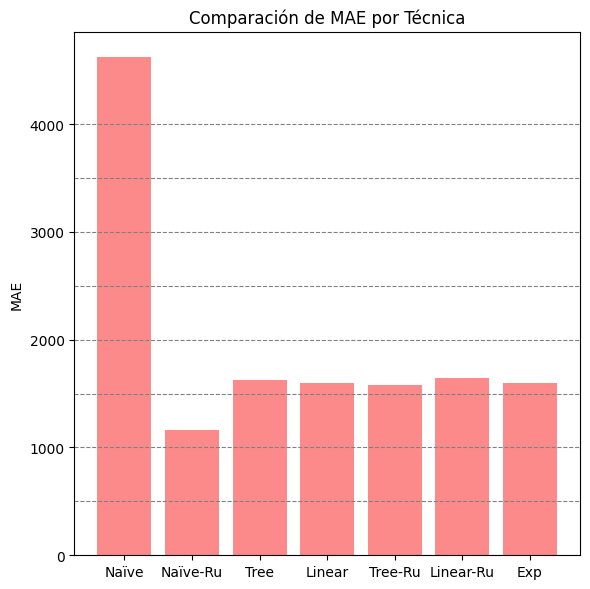

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

tecnicas = ['Naïve','Naïve-Ru', 'Tree', 'Linear' ,'Tree-Ru', 'Linear-Ru', 'Exp']

sns.set_palette("blend:#FD8A8A,#9EA1D4")

fig, axs = plt.subplots(1, 1, figsize=(6, 6))


axs.bar(tecnicas, MAE)
axs.set_ylabel('MAE')
axs.set_title('Comparación de MAE por Técnica')

for i in range(0, int(np.round(max(MAE)/500)) * 500, 500):
    axs.axhline(i, color='gray', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()


In [ ]:
indices_mejores_mae = sorted(range(len(MAE)), key=lambda i: MAE[i])[:3]
print(f'Los tres mejores modelos son:{[tecnicas[i] for i in indices_mejores_mae]} con MAE de {[MAE[i] for i in indices_mejores_mae]}, respectivamente.')

Los tres mejores modelos son:['Naïve-Ru', 'Tree-Ru', 'Exp'] con MAE de [1165.3333333333333, 1583.5833333333333, 1595.8943897447816], respectivamente.


Let's see if we can improve these results:

## **3.4. ARMA models**


### **3.4.1 AR**


The idea of an AR model is to assume that the next value in the time series is calculated as a weighted sum of the previous $p$ values in the series plus a random normal term (white noise). Thus, the assumption of AR is that the time series can be predicted as

$$
\hat{X}(t) = \phi_1X(t-1) + \phi_2X(t-2) + \ldots + \phi_p X(t-p) + \epsilon(t),
$$

where $\phi_i \in \mathbb{R}$ are constants and $\epsilon(t)$ is a random variable with normal distribution with mean $0$ (and fixed standard deviation).

Note that this form includes some of the above models, such as exponential smoothing ($\phi_i = \alpha(1-\alpha)^{i-1}$) or regression with a linear model.

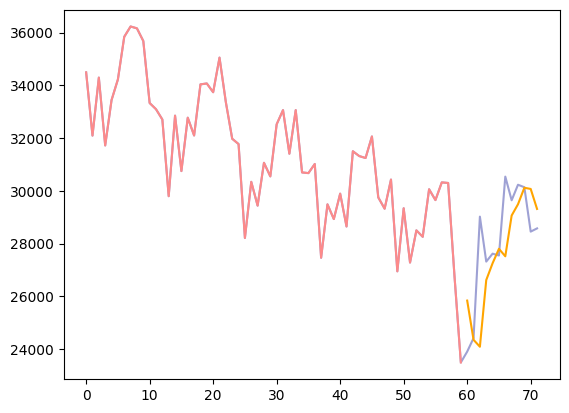

In [ ]:
def generate_next_value_AR(X, phis, sigma, t):
    return sum([phis[i-1]*X[t-i] for i in range(1,len(phis)+1)]) + np.random.normal(loc = 0, scale = sigma)

X_hat_series = X
phis = [0.5,0.3,0.2]

for t in T_missing:
    X_hat_series = np.hstack((X_hat_series, generate_next_value_AR(X_full, phis, 6, t)))

plt.plot(X_full, color='#9EA1D4')
plt.plot(X, color='#FD8A8A')
plt.plot(T_missing, X_hat_series[T_missing], color='orange')
plt.show()

In [ ]:
print(mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))

1246.8015664382092


In [ ]:
tecnicas.append('AR')
MAE.append(mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))



---



The optimal coefficients $\phi_i$ can be estimated from the current data to best fit the series. Typical approaches pose the problem as a least squares problem or the calculation of a maximum likelihood estimator (MLE).

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
for p in range(5,-1,-1):
  model = ARIMA(X, order=(p,0,0))
  model_fit = model.fit()
  X_hat_series = model_fit.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)
  print(p, mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))


5 1537.970499791174
4 1650.512300093202
3 1179.6840927262085
2 1438.7170701480165
1 1250.0549227851625
0 3192.884746841235


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(X, order=(3,0,0))  # el order nos ayudará identificar un modelo AR con estructura: (p,0,0)
model_fit = model.fit()
X_hat_series = model_fit.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)

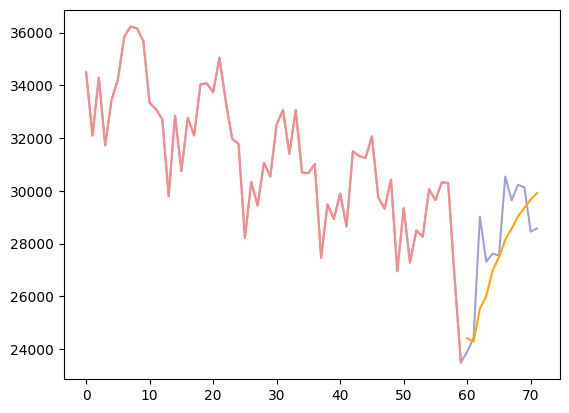

In [ ]:
plt.plot(X_full, color='#9EA1D4')
plt.plot(X, color='#FD8A8A')
plt.plot(T_missing, X_hat_series[T_missing], color='orange')
plt.show()

In [ ]:
print(mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))

1179.6840927262085


In [ ]:
tecnicas.append('AR-auto')
MAE.append(mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))



---



**w/ roll-up**

In [ ]:
X_hat_series = X
for t in T_missing:
    series = X
    model = ARIMA(X_full[:t], order=(3,0,0))
    model_fit = model.fit()
    X_hat_series = np.hstack((X_hat_series, model_fit.predict(start=t,end=t,dynamic=True)))

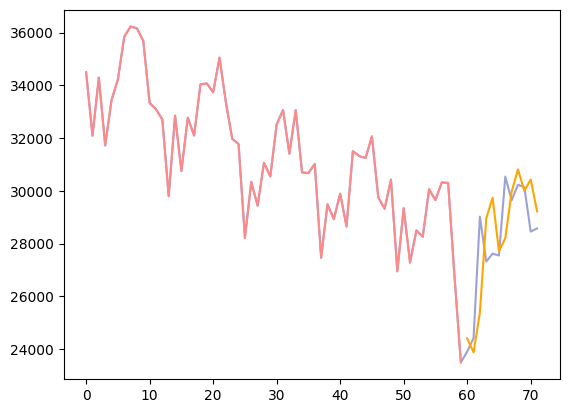

In [ ]:
plt.plot(X_full, color='#9EA1D4')
plt.plot(X, color='#FD8A8A')
plt.plot(T_missing, X_hat_series[T_missing], color='orange')
plt.show()

In [ ]:
print(mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))

1217.1412856731224


In [ ]:
tecnicas.append('AR-auto-ru')
MAE.append(mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))

### **3.4.2. MA**

Unlike AR models, MA models assume that each value in the time series does not depend on the previous value, but is a random combination of several white noises. However, the white noises are nested so that their values resonate in the following values of the series. Explicitly written, an MA model has the form
$$
\hat{X}(t) = \theta_1\epsilon(t-1) + \theta_2\epsilon(t-2) + \ldots + \theta_q \epsilon(t-q),
$$

where $\theta_i \in \mathbb{R}$ are fixed constants and $\epsilon(t')$ are independent normal variables with mean 0 and fixed standard deviation (white noises).

In [ ]:
def generate_next_value_MA(thetas, sigma, epsilons):
    new_epsilon = np.random.normal(loc = 0, scale = sigma)
    epsilons.pop(0)
    epsilons.append(new_epsilon)
    return sum([thetas[i]*epsilons[i] for i in range(len(phis))])

sigma = 6
thetas = [0.5,-0.3,0.2]
epsilons = [np.random.normal(loc = 0, scale = sigma) for i in range(len(thetas))]

X_hat_series = []
for t in T_missing:
    X_hat_series = np.hstack((X_hat_series, generate_next_value_MA(thetas, sigma, epsilons)))


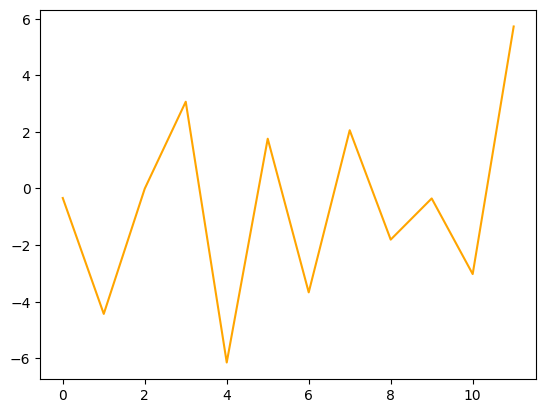

In [ ]:
plt.plot(X_hat_series, color='orange')
plt.show()



---



In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(X, order=(0,0,5))  # el order nos ayudará identificar un modelo MA con estructura: (0,0,p)
model_fit = model.fit()
X_hat_series = model_fit.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)

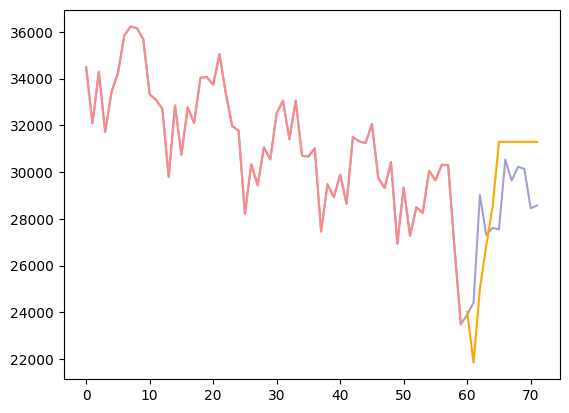

In [ ]:
plt.plot(X_full, color='#9EA1D4')
plt.plot(X, color='#FD8A8A')
plt.plot(T_missing, X_hat_series[T_missing], color='orange')
plt.show()

In [ ]:
print(mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))

1832.4540024829412


In [ ]:
tecnicas.append('MA-auto')
MAE.append(mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))

### **3.4.3. ARMA**


In this type of model, we mix the best of both worlds AR and MA and consider a combined model of the form

$$
\hat{X}(t) = \underbrace{\mu}_{\textrm{Mean}} + \underbrace{\phi_1X(t-1) + \phi_2X(t-2) + \ldots + \phi_p X(t-p) + \epsilon(t)}_{AR} + \underbrace{\theta_1\epsilon(t-1) + \theta_2\epsilon(t-2) + \ldots + \theta_q \epsilon(t-q)}_{MA}.
$$

Here $\phi_i,\theta_i, \mu \in \mathbb{R}$ are constants and $\epsilon(h)$ are white noises (of mean $0$ and fixed standard deviation). Note that the model also includes a constant $\mu$ which allows it to fit a general "underlying level".

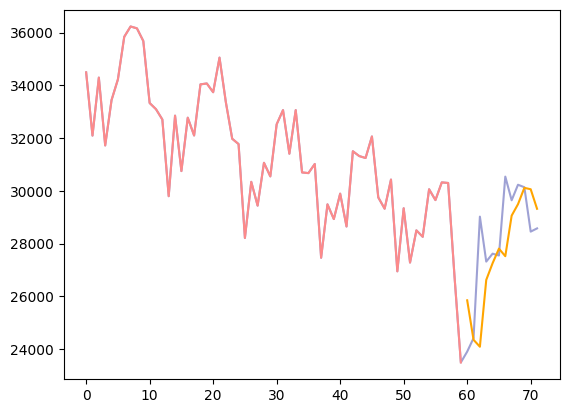

In [ ]:
def generate_next_value_ARMA(X, phis, thetas, mu, sigma, epsilons, t):
    new_epsilon = np.random.normal(loc = 0, scale = sigma)
    epsilons.pop(0)
    epsilons.append(new_epsilon)
    AR = sum([phis[i-1]*X[t-i] for i in range(1,len(phis)+1)]) + np.random.normal(loc = 0, scale = sigma)
    MA = sum([thetas[i]*epsilons[i] for i in range(len(phis))])
    return mu + AR + MA

X_hat_series = X
phis = [0.5,0.3,0.2]
thetas = [0.5,-0.3,0.2,-0.1]
epsilons = [np.random.normal(loc = 0, scale = sigma) for i in range(len(thetas))]
sigma = 6
mu = 2

X_hat_series = X
for t in T_missing:
    X_hat_series = np.hstack((X_hat_series, generate_next_value_ARMA(X_full, phis, thetas, mu, sigma, epsilons, t)))

plt.plot(X_full, color='#9EA1D4')
plt.plot(X, color='#FD8A8A')
plt.plot(T_missing, X_hat_series[T_missing], color='orange')
plt.show()

In [ ]:
print(mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))

1247.2914908670343


In [ ]:
MAE.append(mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))
tecnicas.append('ARMA')



---



We train a model to optimize the parameters:

In [ ]:
# Define the parameters to be explored in the grid search, d = 0 because it is an ARMA model.
p_values = range(0,11)
q_values = range(1,11)

# Initialize variables to store the best results
best_mae = np.inf
best_params = None

# Loop over all parameter combinations
for p in p_values:
      for q in q_values:
          try:
              # Training the ARIMA model with the current parameters
              model = ARIMA(X, order=(p,0,q))
              model_fit = model.fit()
              X_hat_series = model_fit.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)
              mae = mean_absolute_error(X_full[T_missing], X_hat_series[T_missing])

              # Update if we find a better set of parameters
              if mae < best_mae:
                  best_mae = mae
                  best_params = (p, 0, q)

          except:
              continue

# Show the best results
print("Mejor conjunto de parámetros:", best_params)
print("Mejor resultado (MAE):", best_mae)

Mejor conjunto de parámetros: (1, 0, 1)
Mejor resultado (MAE): 1202.8187248020377


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(X, order=(1,0,1))
model_fit = model.fit()
X_hat_series = model_fit.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)

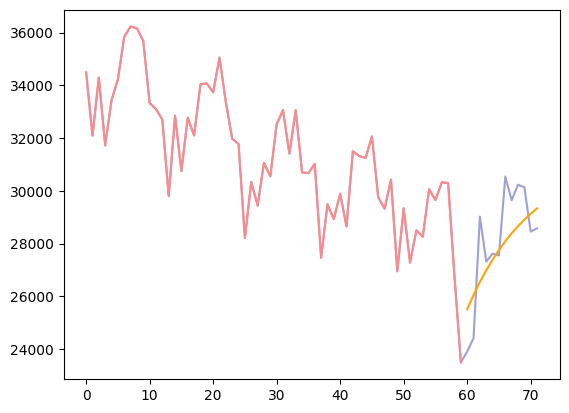

In [ ]:
plt.plot(X_full, color='#9EA1D4')
plt.plot(X, color='#FD8A8A')
plt.plot(T_missing, X_hat_series[T_missing], color='orange')
plt.show()

In [ ]:
print(mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))

1202.8187248020377


In [ ]:
tecnicas.append('ARMA-auto')
MAE.append(mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))



---



In [ ]:
X_hat_series = X
for t in T_missing:
    series = X
    model = ARIMA(X_full[:t], order=(1,0,1))
    model_fit = model.fit()
    X_hat_series = np.hstack((X_hat_series, model_fit.predict(start=t,end=t,dynamic=True)))

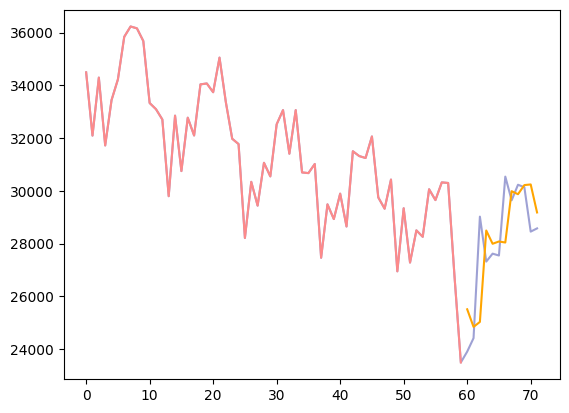

In [ ]:
plt.plot(X_full, color='#9EA1D4')
plt.plot(X, color='#FD8A8A')
plt.plot(T_missing, X_hat_series[T_missing], color='orange')
plt.show()

In [ ]:
print(mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))

1148.8868223453007


In [ ]:
tecnicas.append('ARMA-auto-ru')
MAE.append(mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))



---



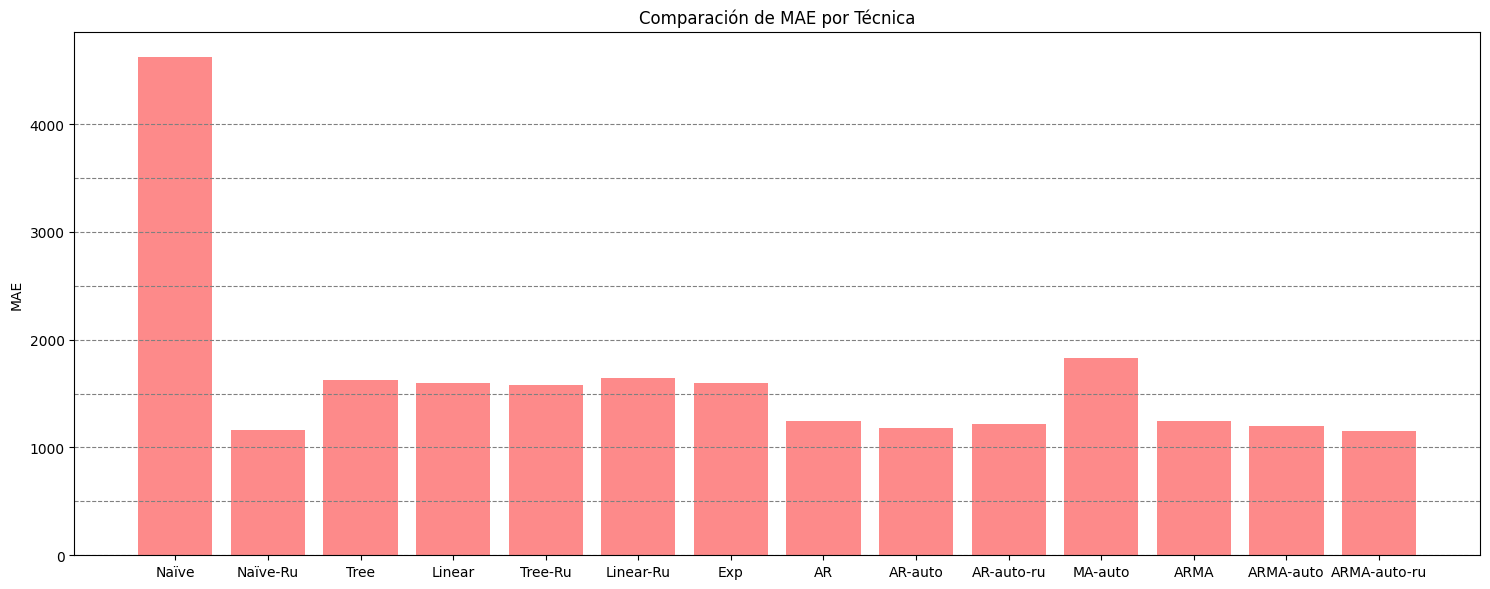

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(15,6))

# Gráfico de Barras de los MAE
axs.bar(tecnicas, MAE)
axs.set_ylabel('MAE')
axs.set_title('Comparación de MAE por Técnica')

# Agregar líneas horizontales en intervalos de 500 en el eje y
for i in range(0, int(np.round(max(MAE)/500)) * 500, 500):
    axs.axhline(i, color='gray', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

In [ ]:
indices_mejores_mae = sorted(range(len(MAE)), key=lambda i: MAE[i])[:3]
print(f'Los tres mejores modelos son:{[tecnicas[i] for i in indices_mejores_mae]} con MAE de {[MAE[i] for i in indices_mejores_mae]}, respectivamente.')

Los tres mejores modelos son:['ARMA-auto-ru', 'Naïve-Ru', 'AR-auto'] con MAE de [1148.8868223453007, 1165.3333333333333, 1179.6840927262085], respectivamente.


## **3.5. ARIMA models**


An ARIMA (AutoRegressive Integrated Moving Average) model is nothing more than an ARMA model in which the time series is differenced $d$ times to reach stationarity, $D^dX$. The general form of an ARIMA model is therefore


$$
\widehat{D^dX}(t) = \mu + \phi_1 D^dX(t-1) + \phi_2 D^dX(t-2) + \ldots + \phi_p D^dX(t-p) + \epsilon(t) + \theta_1\epsilon(t-1) + \theta_2\epsilon(t-2) + \ldots + \theta_q \epsilon(t-q).
$$


Here $\phi_i,\theta_i, \mu \in \mathbb{R}$ are constants and $\epsilon(h)$ are white noises (of mean $0$ and fixed standard deviation). The parameters $p$ (AR model length), $q$ (MA model length) and $d$ (degree of differencing) are called the ARIMA model parameters.

In our previous study, we have seen a possibility that our ensemble is non-stationary, so we will test this type of model to see if it decreases the error.

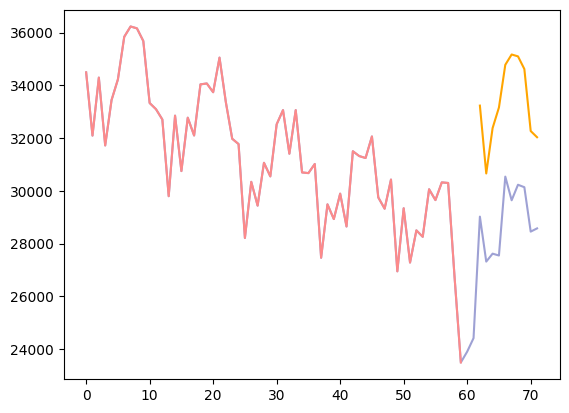

In [ ]:
# Operator D
def differentiate(X):
    return X - X.shift(1)

# Inverse of D
def integrate(X, Y):
    return Y + X.shift(1)

def generate_next_value_ARIMA(X, phis, thetas, d, mu, sigma, epsilons, t):
    DX = [X]

    # Differentiate the series
    for i in range(d):
        DX.append(differentiate(DX[-1]))

    # Predict the differentiated series using a ARMA model
    new_epsilon = np.random.normal(loc = 0, scale = sigma)
    epsilons.pop(0)
    epsilons.append(new_epsilon)
    AR = sum([phis[i-1]*DX[-1][t-i] for i in range(1,len(phis)+1)]) + np.random.normal(loc = 0, scale = sigma)
    MA = sum([thetas[i]*epsilons[i] for i in range(len(phis))])
    Y = DX[-1] + [mu + AR + MA]

    # Integrate to recover the non-differentiated series
    for i in range(d-1,-1,-1):
        Y = integrate(DX[i],Y)

    return Y

# Reload the time series
X = X_full[:last_time]
T_missing = range(last_time, X_full.shape[0])

X_hat_series = X
phis = [0.5,0.3,0.2]
thetas = [0.5,-0.3,0.2,-0.1]
epsilons = [np.random.normal(loc = 0, scale = sigma) for i in range(len(thetas))]
sigma = 6
mu = 2
d = 2

X_hat_series = X
for t in T_missing:
    X_hat_series = np.hstack((X_hat_series, generate_next_value_ARIMA(X_full, phis, thetas, d, mu, sigma, epsilons, t)))

plt.plot(X_full, color='#9EA1D4')
plt.plot(X, color='#FD8A8A')
plt.plot(T_missing, X_hat_series[T_missing], color='orange')
plt.show()

We can observe without calculating the MAE that the predictions are too far off.



---



We train a model to optimize the parameters:

In [ ]:

p_values = range(0,6)
d_values = range(1,3) # we force it to have a differentiation value d
q_values = range(0,6)


best_mae = np.inf
best_params = None

for p in p_values:
  for d in d_values:
      for q in q_values:
          try:
              model = ARIMA(X, order=(p,d,q))
              model_fit = model.fit()
              X_hat_series = model_fit.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)
              mae = mean_absolute_error(X_full[T_missing], X_hat_series[T_missing])

              if mae < best_mae:
                  best_mae = mae
                  best_params = (p, d, q)

          except:
              continue

print("Mejor conjunto de parámetros:", best_params)
print("Mejor resultado (MAE):", best_mae)

Mejor conjunto de parámetros: (0, 1, 1)
Mejor resultado (MAE): 4119.419204557757


Including the `d` parameter does not give good results.



---



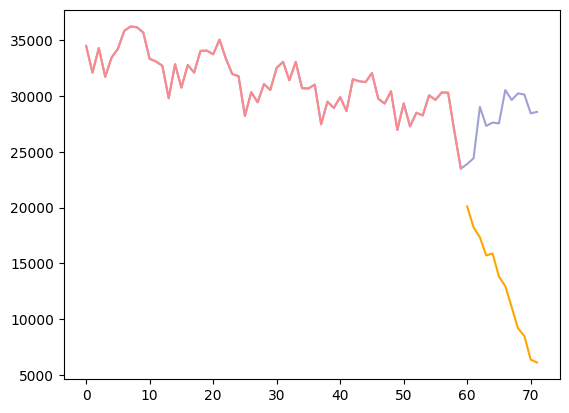

In [ ]:
X_hat_series = X
for t in T_missing:
    series = X
    model = ARIMA(X_full[:t], order=(0,1,1))
    arima_auto = model.fit()
    X_hat_series = np.hstack((X_hat_series, model_fit.predict(start=t,end=t,dynamic=True)))

plt.plot(X_full, color='#9EA1D4')
plt.plot(X, color='#FD8A8A')
plt.plot(T_missing, X_hat_series[T_missing], color='orange')
plt.show()

In [ ]:
print(mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))

15181.287825879665




---



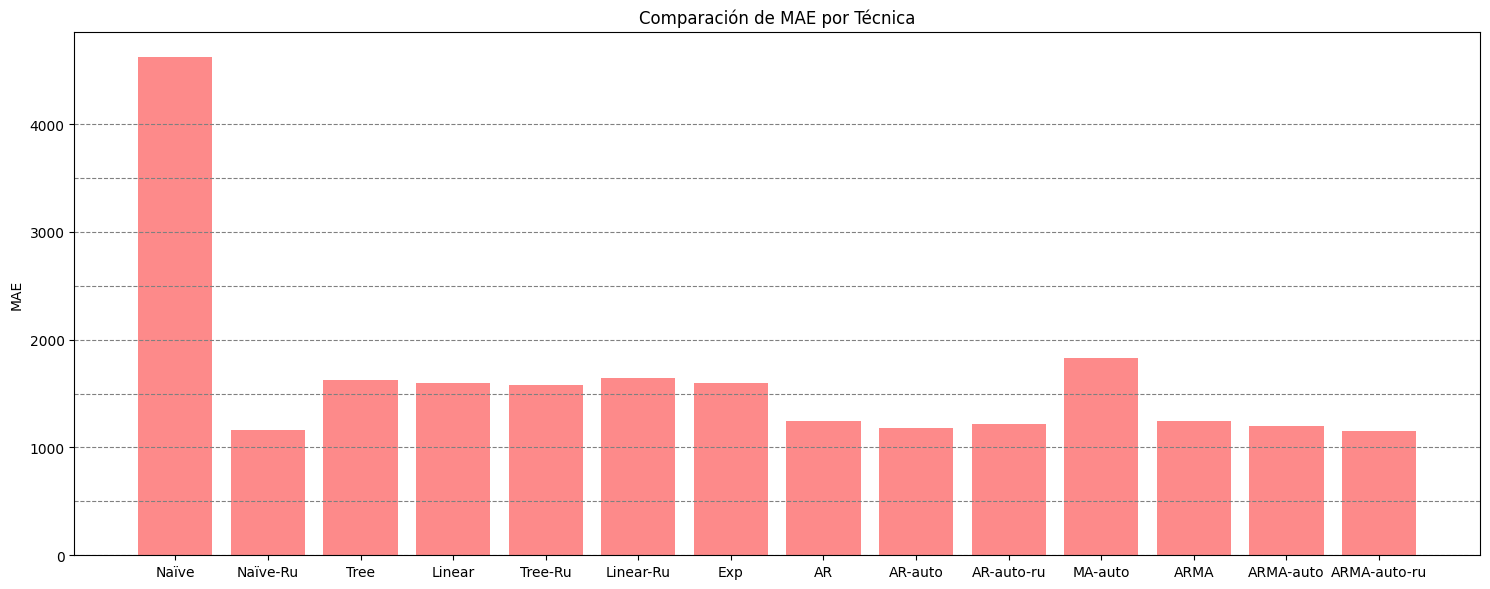

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(15,6))

axs.bar(tecnicas, MAE)
axs.set_ylabel('MAE')
axs.set_title('Comparación de MAE por Técnica')

for i in range(0, int(np.round(max(MAE)/500)) * 500, 500):
    axs.axhline(i, color='gray', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

In [ ]:
indices_mejores_mae = sorted(range(len(MAE)), key=lambda i: MAE[i])[:3]
print(f'Los tres mejores modelos son:{[tecnicas[i] for i in indices_mejores_mae]} con MAE de {[MAE[i] for i in indices_mejores_mae]}, respectivamente.')

Los tres mejores modelos son:['ARMA-auto-ru', 'Naïve-Ru', 'AR-auto'] con MAE de [1148.8868223453007, 1165.3333333333333, 1179.6840927262085], respectivamente.


### **ARIMA w/ auto-arima**

If we use the `auto_arima()` function of the `pmdarima` library we can perform an automatic search for the best ARIMA model for our data set. This function performs an exhaustive search for ARIMA models and selects the best model based on criteria such as the AIC (Akaike Information Criterion) and the BIC (Bayesian Information Criterion).

In [ ]:
X_full_aux = df.groupby('fecha')['count'].sum().reset_index()
X_aux = X_full_aux.set_index('fecha')
X_2 = X_aux[0:last_time]

In [ ]:
import pmdarima as pm
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(X_2,
                      start_p=1,
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=True, # No Seasonality for standard ARIMA
                      trace=False, #logs
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
print(ARIMA_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   60
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -526.985
Date:                Fri, 22 Dec 2023   AIC                           1063.969
Time:                        17:30:29   BIC                           1074.441
Sample:                    01-01-2016   HQIC                          1068.065
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3700.7023   3731.379      0.992      0.321   -3612.666     1.1e+04
ar.L1          0.6298      0.117      5.371      0.000       0.400       0.860
ar.L2          0.5105      0.206      2.480      0.0

---
**Model diagnosis**

The `plot_diagnostics` function results in four plots: **Standardized residuals**, **Histogram plus estimated density (KDE)**, **Normal Q-Q plot**, and an **Autocorrelation Function (ACF) plot**.

We can interpret the model as a good fit based on the following conditions.

- **Standardized residuals**: There are no obvious patterns in the residuals, with values having a mean of zero and uniform variance.
- **Histogram plus estimated density (KDE)**: The KDE curve should closely resemble the normal distribution (labeled as N(0,1) on the plot).
- **Normal Q-Q plot**: Most data points should fall on the straight line.
- **Autocorrelation Function (ACF) plot**: 95% of correlations for a lag greater than zero should not be significant. The gray shaded area is the confidence band, and if values fall outside of this, they are statistically significant.

<Figure size 640x480 with 0 Axes>

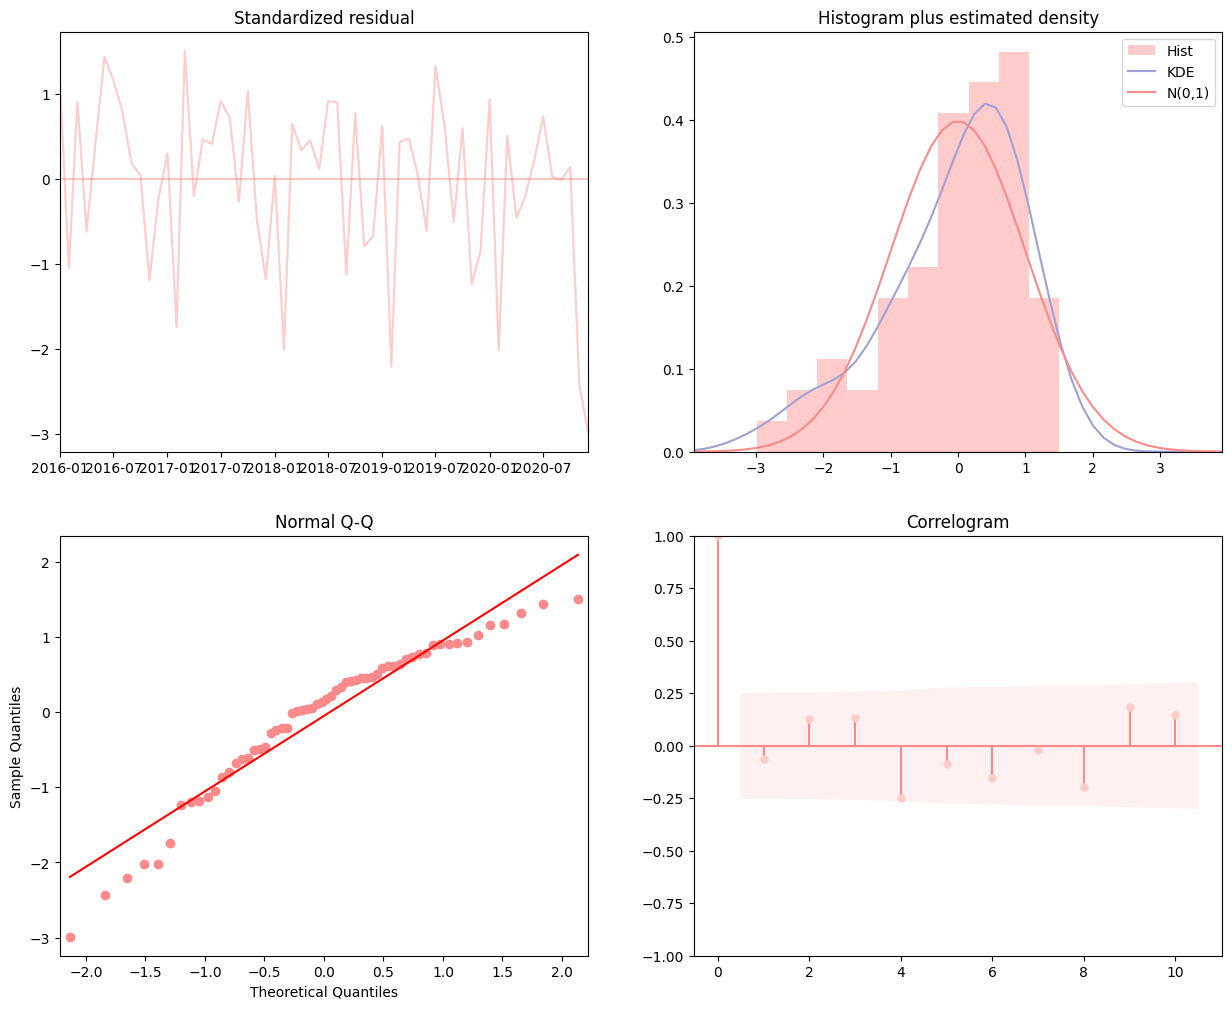

In [ ]:
import matplotlib.pyplot as plt

plt.clf()
original_style = plt.rcParams.copy()

# custom colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#FFCBCB', '#9EA1D4', '#FD8A8A', '#A8D1D1'])

ARIMA_model.plot_diagnostics(figsize=(15, 12))

plt.rcParams.update(original_style)
plt.show()
plt.show()

- **Standardized residuals**: The values are inconsistent.
- **Histogram plus estimated density (KDE)**: The KDE curve is very similar to the normal distribution.
- **Normal Q-Q plot**: Most points are very close to the straight line.
- **Autocorrelation Function (ACF) plot**: 95% of correlations for a lag greater than zero fall within the shaded region, meaning they are not significant.

We create a function to predict the data and add a confidence interval.

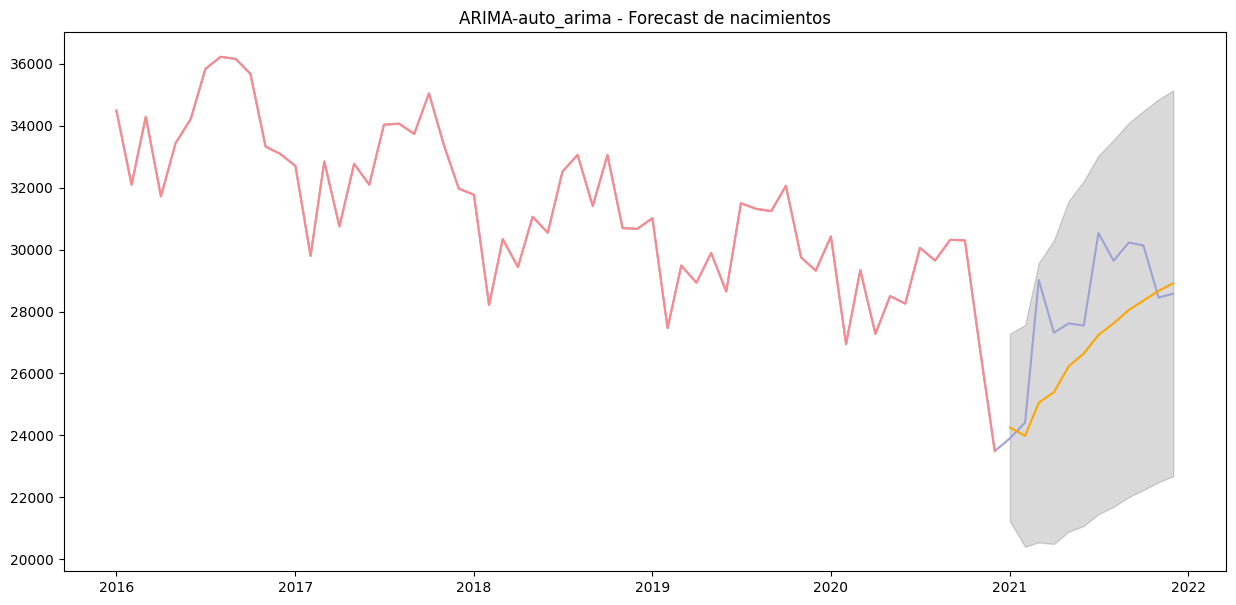

Error MAE de 1566.180753799108


In [ ]:
def forecast(ARIMA_model, tecnica, periods=len(T_missing)):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(X_2.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(X_aux, color='#9EA1D4')
    plt.plot(X_2, color='#FD8A8A')
    plt.plot(fitted_series, color='orange')
    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                    color='k', alpha=.15)

    plt.title(f"{tecnica} - Forecast de nacimientos")
    plt.show()

    print(f'Error MAE de {mean_absolute_error(X_full_aux.iloc[T_missing]["count"], fitted_series.values)}')

    tecnicas.append(tecnica)
    MAE.append(mean_absolute_error(X_full_aux.iloc[T_missing]["count"], X_hat_series[T_missing]))

forecast(ARIMA_model, tecnica='ARIMA-auto_arima')

**SARIMA with auto-arima**

In the previous training, seasonality was not taken into account. What we will do is use a SARIMA model that includes seasonal decomposition.

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(X_2, start_p=1, start_q=1,
                         test='adf',
                         max_p=6, max_q=6,
                         m=12, #12 is the frequncy of the cycle
                         start_P=0,
                         seasonal=True, #set to seasonal
                         d=None,
                         D=2, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
print(SARIMA_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   60
Model:             SARIMAX(0, 2, 1)x(2, 2, [], 12)   Log Likelihood                -300.535
Date:                             Fri, 22 Dec 2023   AIC                            611.070
Time:                                     17:30:57   BIC                            618.702
Sample:                                 01-01-2016   HQIC                           613.673
                                      - 12-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -234.9489    153.531     -1.530      0.126    -535.864      65.967
ma.L1         -0.5304      

---

**Model diagnosis**

<Figure size 640x480 with 0 Axes>

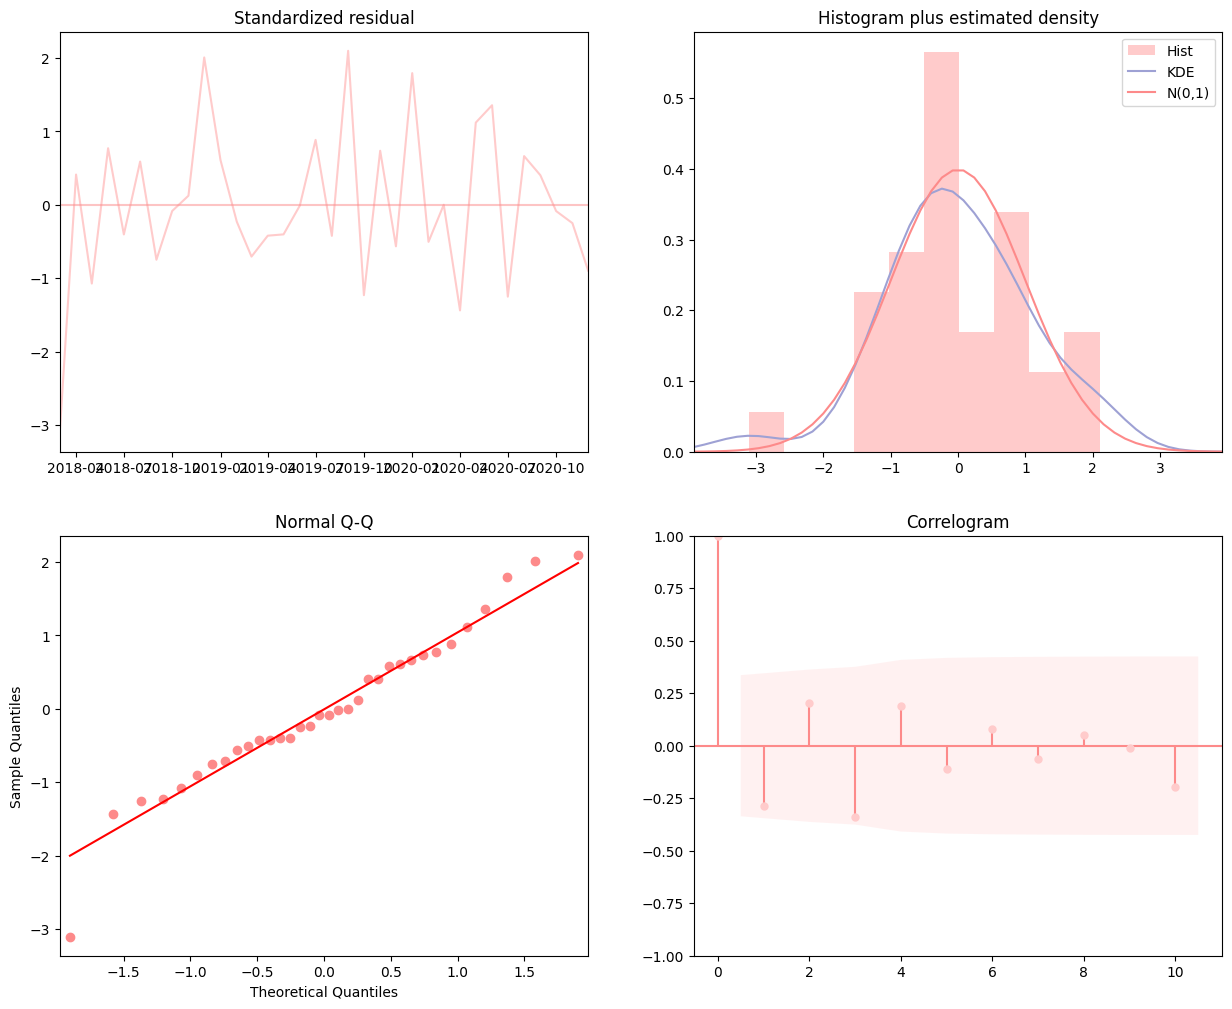

In [ ]:
import matplotlib.pyplot as plt

plt.clf()
original_style = plt.rcParams.copy()

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#FFCBCB', '#9EA1D4', '#FD8A8A', '#A8D1D1'])

SARIMA_model.plot_diagnostics(figsize=(15, 12))

plt.rcParams.update(original_style)
plt.show()
plt.show()


- **Standardized Residuals**: The values are still quite inconsistent and fluctuating.
- **Histogram plus KDE Estimate**: The curve hasn't changed much compared to ARIMA.
- **Normal Q-Q Plot**: Now the points are much more aligned with the straight line.
- **Autocorrelation Function (ACF) Plot**: All values are within the shaded region.

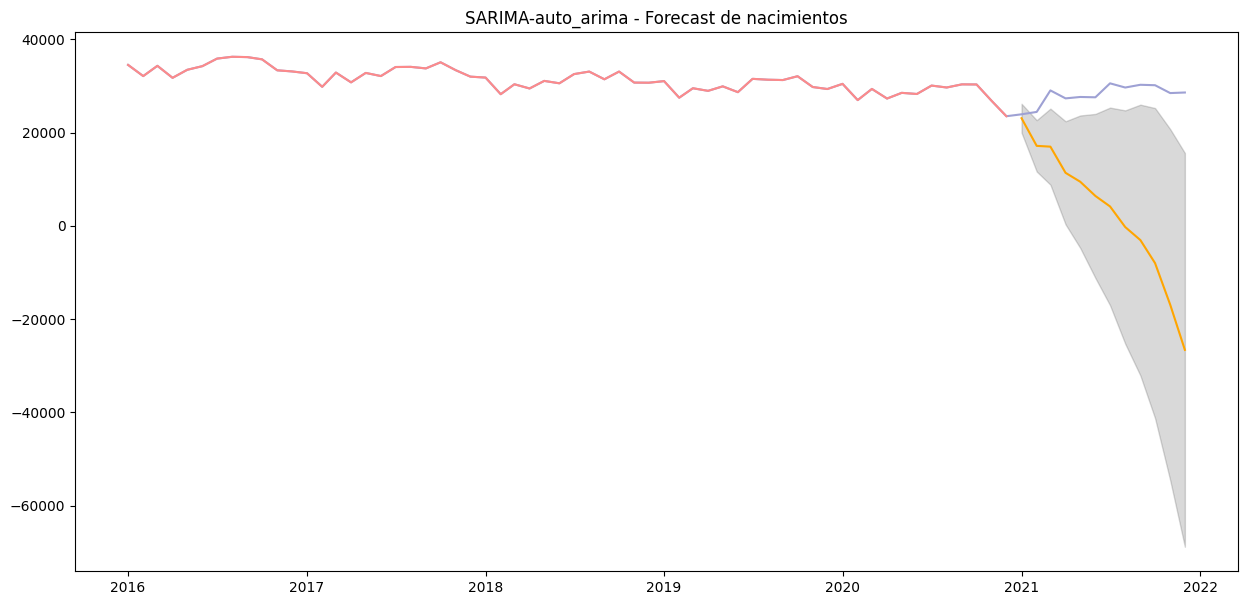

Error MAE de 25302.668073997713


In [ ]:
forecast(SARIMA_model, tecnica='SARIMA-auto_arima')

The predictions deviate significantly from the actual values.

## **3.6. Modelos SARIMAX**

The SARIMAX model, which stands for "Seasonal Autoregressive Integrated Moving Average with Exogenous Factors," is a powerful extension of the ARIMA (AutoRegressive Integrated Moving Average) model that incorporates both seasonal components and exogenous variables to enhance prediction capability in time series.

To train the SARIMAX, we will start with our 2 best models obtained with `ARIMA()`: AR and ARMA with a roll-up. Therefore, we will try an order of (1,0,1) or (3,0,0).

In [ ]:
"""
import statsmodels.api as sm

p_values = [1,3]
d_values = [0]
q_values = [0, 1]

P_values = range(0,6)
D_values = range(0,6)
Q_values = range(0,6)
s_values = [12]  # estacionalidad anual

best_mae = float('inf')
best_params = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for s in s_values:
                          try:
                            order = (p, d, q)
                            seasonal_order = (P, D, Q, s)

                            model = sm.tsa.statespace.SARIMAX(X, order=order, seasonal_order=seasonal_order)
                            results = model.fit()
                            X_hat_series = model_fit.predict(start=T_missing[0],end=T_missing[-1],dynamic=True)
                            mae = mean_absolute_error(X_full[T_missing], X_hat_series[T_missing])

                            if mae < best_mae:
                                best_mae = mae
                                best_params = (order, seasonal_order)

                          except:
                            continue

print(f"Our best parameters: {best_params} con MAE de {best_mae}.")

"""


' \nimport statsmodels.api as sm\n# Combinaciones para los parámetros no estacionales (p, d, q)\np_values = [1,3]\nd_values = [0]\nq_values = [0, 1]\n\n# Combinaciones para los parámetros estacionales (P, D, Q, s)\nP_values = range(0,6)\nD_values = range(0,6)\nQ_values = range(0,6)\ns_values = [12]  # estacionalidad anual\n\n# Realizar la búsqueda de cuadrícula\nbest_mae = float(\'inf\')\nbest_params = None\n\nfor p in p_values:\n    for d in d_values:\n        for q in q_values:\n            for P in P_values:\n                for D in D_values:\n                    for Q in Q_values:\n                        for s in s_values:\n                          try:\n                            order = (p, d, q)\n                            seasonal_order = (P, D, Q, s)\n\n                            model = sm.tsa.statespace.SARIMAX(X, order=order, seasonal_order=seasonal_order)\n                            results = model.fit()\n                            X_hat_series = model_fit.predict(



---



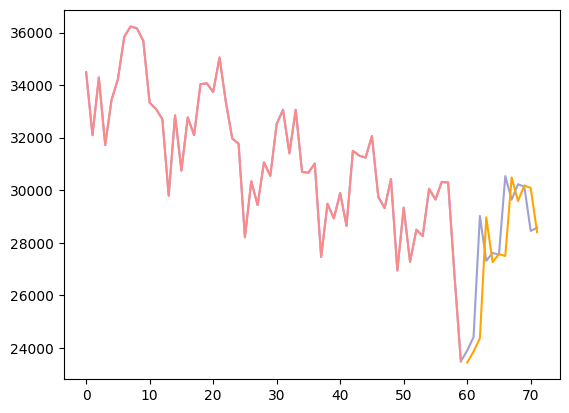

In [ ]:
import statsmodels.api as sm

X_hat_series = X
for t in T_missing:
    series = X
    # The seasonal_order parameters of SARIMA are the same as for ARIMA
    # but the last one includes the period of the season.
    model = sm.tsa.statespace.SARIMAX(X_full[:t], order=(1, 0, 0), seasonal_order=(0,0,0,12))
    model_fit = model.fit()
    X_hat_series = np.hstack((X_hat_series, model_fit.predict(start=t,end=t,dynamic=True)))

plt.plot(X_full, color='#9EA1D4')
plt.plot(X, color='#FD8A8A')
plt.plot(T_missing, X_hat_series[T_missing], color='orange')
plt.show()

In [ ]:
print(mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))

1171.5347864478456


In [ ]:
tecnicas.append('SARIMAX-ru')
MAE.append(mean_absolute_error(X_full[T_missing], X_hat_series[T_missing]))

**SARIMAX w/ auto-arima**

In [ ]:
#adding exogenous variable
X_aux['month_index'] = X_aux.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(X_2, exogenous=X_aux[['month_index']],
                           start_p=0, start_q=0,
                           test='adf',
                           max_p=6, max_q=6, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=2,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   60
Model:             SARIMAX(0, 2, 1)x(2, 2, [], 12)   Log Likelihood                -300.535
Date:                             Fri, 22 Dec 2023   AIC                            611.070
Time:                                     17:31:25   BIC                            618.702
Sample:                                 01-01-2016   HQIC                           613.673
                                      - 12-01-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -234.9489    153.531     -1.530      0.126    -535.864      65.967
ma.L1         -0.5304      0.138     -3.830      0.000      -0.802      -0.259
ar.S.L12      -0.3613      0.160     -2.263      0.024      -0.674      -0.048
ar.S.L24      -0.1645      0.076     -2.153      0.031      -0.314      -0.015
sigma2      2.498e+06   9.26e+05      2.696      0.007    6.82e+05    4.31e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.06   Jarque-Bera (JB):                 1.32
Prob(Q):                              0.08   Prob(JB):                         0.52
Heteroskedasticity (H):               0.50   Skew:                            -0.25
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

---

**Model diagnosis**

<Figure size 640x480 with 0 Axes>

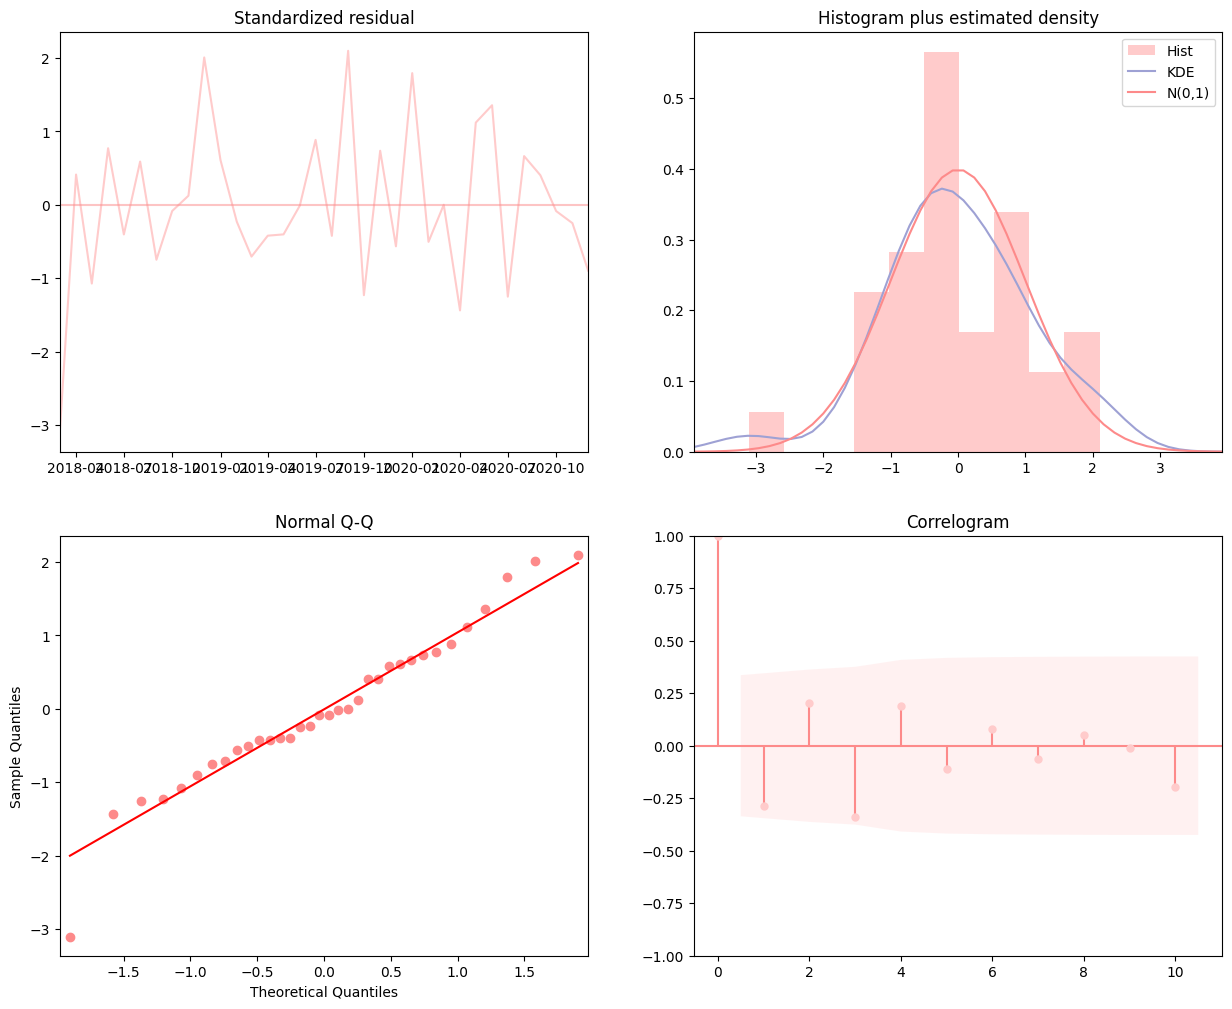

In [ ]:
import matplotlib.pyplot as plt

plt.clf()
original_style = plt.rcParams.copy()

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#FFCBCB', '#9EA1D4', '#FD8A8A', '#A8D1D1'])

SARIMAX_model.plot_diagnostics(figsize=(15, 12))

plt.rcParams.update(original_style)
plt.show()

- **Standardized Residuals**: The values are still quite inconsistent and fluctuating.
- **Histogram plus KDE Estimate**: The curve hasn't changed much compared to ARIMA.
- **Normal Q-Q Plot**: Now the points are much more aligned with the straight line.
- **Autocorrelation Function (ACF) Plot**: All values are within the shaded region.

<Figure size 640x480 with 0 Axes>

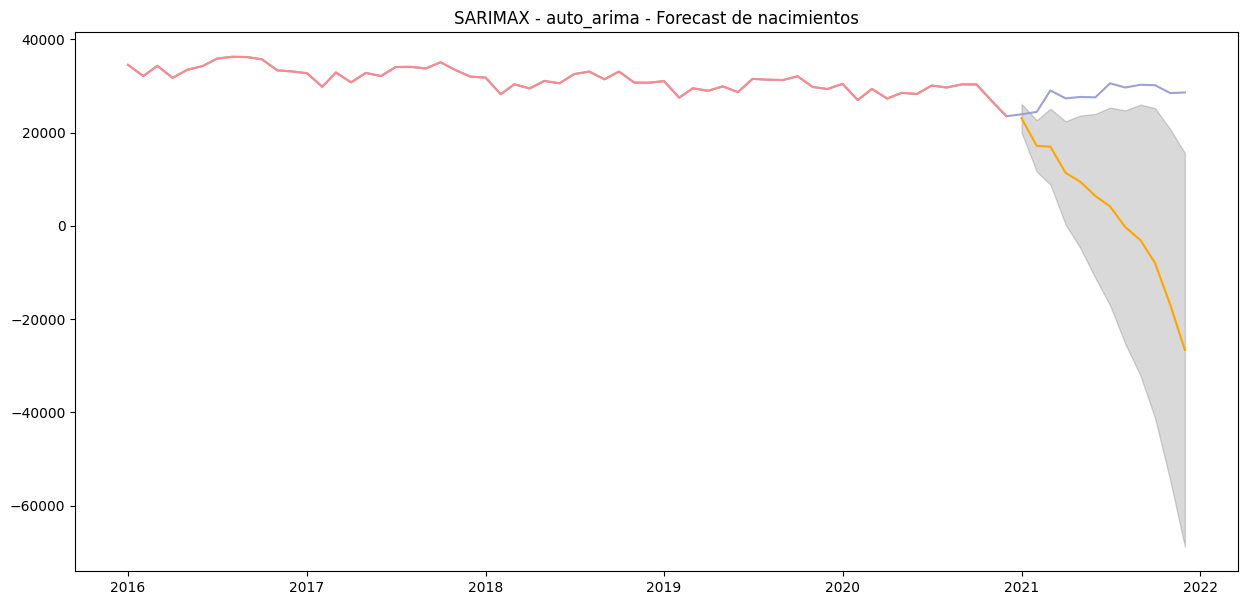

Error MAE de 25302.668073997713


In [ ]:
def sarimax_forecast(SARIMAX_model, tecnica, periods=len(T_missing)):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(X_2.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(X_2.index[-1]+ pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods,
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(X_2.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.clf()
    plt.figure(figsize=(15,7))
    plt.plot(X_aux['count'], color='#9EA1D4')
    plt.plot(X_2, color='#FD8A8A')
    plt.plot(fitted_series, color='orange')
    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                    color='k', alpha=.15)

    plt.title(f"{tecnica} - Forecast de nacimientos")
    plt.show()

    print(f'Error MAE de {mean_absolute_error(X_full_aux.iloc[T_missing]["count"], fitted_series.values)}')

    tecnicas.append(tecnica)
    MAE.append(mean_absolute_error(X_full_aux.iloc[T_missing]["count"], fitted_series.values))

sarimax_forecast(SARIMAX_model, tecnica='SARIMAX - auto_arima')

## **3.6 LSTM**

Unlike conventional neural networks, LSTM (Long Short-Term Memory) networks have special memory units that allow them to retain and access relevant information over long sequences. This long-term memory mechanism translates into a unique ability to capture complex temporal patterns and learn dependencies at different temporal scales.

In [ ]:
# load the dataset again

X_full = df.groupby('fecha')['count'].sum().reset_index()
last_time = X_full[X_full['fecha'].dt.year < 2021].index[-1] +1 # Index of the last sample of the year 2020

X_full = X_full['count']
X = X_full[0:last_time]
T_missing = range(last_time, X_full.shape[0])

In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# We obtain a supervised learning problem with X and y.
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# Differencing to make the time series stationary is equivalent to using `pd.diff()`.
def difference(dataset, interval=1):
	diff = [0] # the first value is always NaN
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# We undo the differencing.
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# We scale the training and test data to [-1, 1].
def scale(train, test):
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# We reverse the scaling to obtain the actual values.
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# We fit the neural network.
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# Prediction
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

1/1 [==============================] - 0s 21ms/step
Month=1, Predicted=22919.462084, Expected=23902.000000
1/1 [==============================] - 0s 19ms/step
Month=2, Predicted=18890.601953, Expected=24413.000000
1/1 [==============================] - 0s 26ms/step
Month=3, Predicted=19733.107875, Expected=29020.000000
1/1 [==============================] - 0s 20ms/step
Month=4, Predicted=31096.493449, Expected=27315.000000
1/1 [==============================] - 0s 20ms/step
Month=5, Predicted=26693.537600, Expected=27616.000000
1/1 [==============================] - 0s 17ms/step
Month=6, Predicted=26222.526063, Expected=27546.000000
1/1 [==============================] - 0s 20ms/step
Month=7, Predicted=26611.841252, Expected=30538.000000
1/1 [==============================] - 0s 24ms/step
Month=8, Predicted=31383.333086, Expected=29640.000000
1/1 [==============================] - 0s 22ms/step
Month=9, Predicted=31411.672520, Expected=30229.000000
1/1 [==============================] 

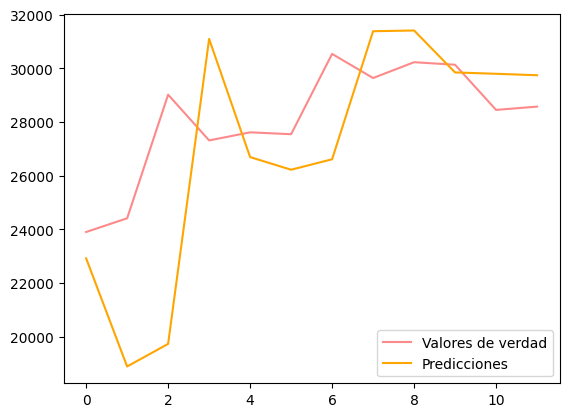

In [ ]:
np.random.seed(0)
# We make the time series stationary.
raw_values = X_full.values
diff_values = difference(X_full, 1)

# We obtain a supervised learning problem with X and y.
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# train and test sets
train, test = supervised_values[0:last_time], supervised_values[last_time:]

# aplying scaler
scaler, train_scaled, test_scaled = scale(train, test)

# fit model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecasting values
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# Validation on the test set.
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# rversing the scaling and differencing
	yhat = invert_scale(scaler, X, yhat)
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# storing results
	predictions.append(yhat)
	expected = raw_values[len(train) + i]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# Error
mae = mean_absolute_error(raw_values[-12:], predictions)
print('Test MAE: %.3f' % mae)
# Plot
plt.plot(raw_values[-12:], color='#FD8A8A', label='Valores de verdad')
plt.plot(predictions, color='orange', label='Predicciones')
plt.legend()
plt.show()

Vemos que se alcanza un error alto también

In [ ]:
tecnicas.append('LSTM')
MAE.append(mae)

## **3.7. Results**

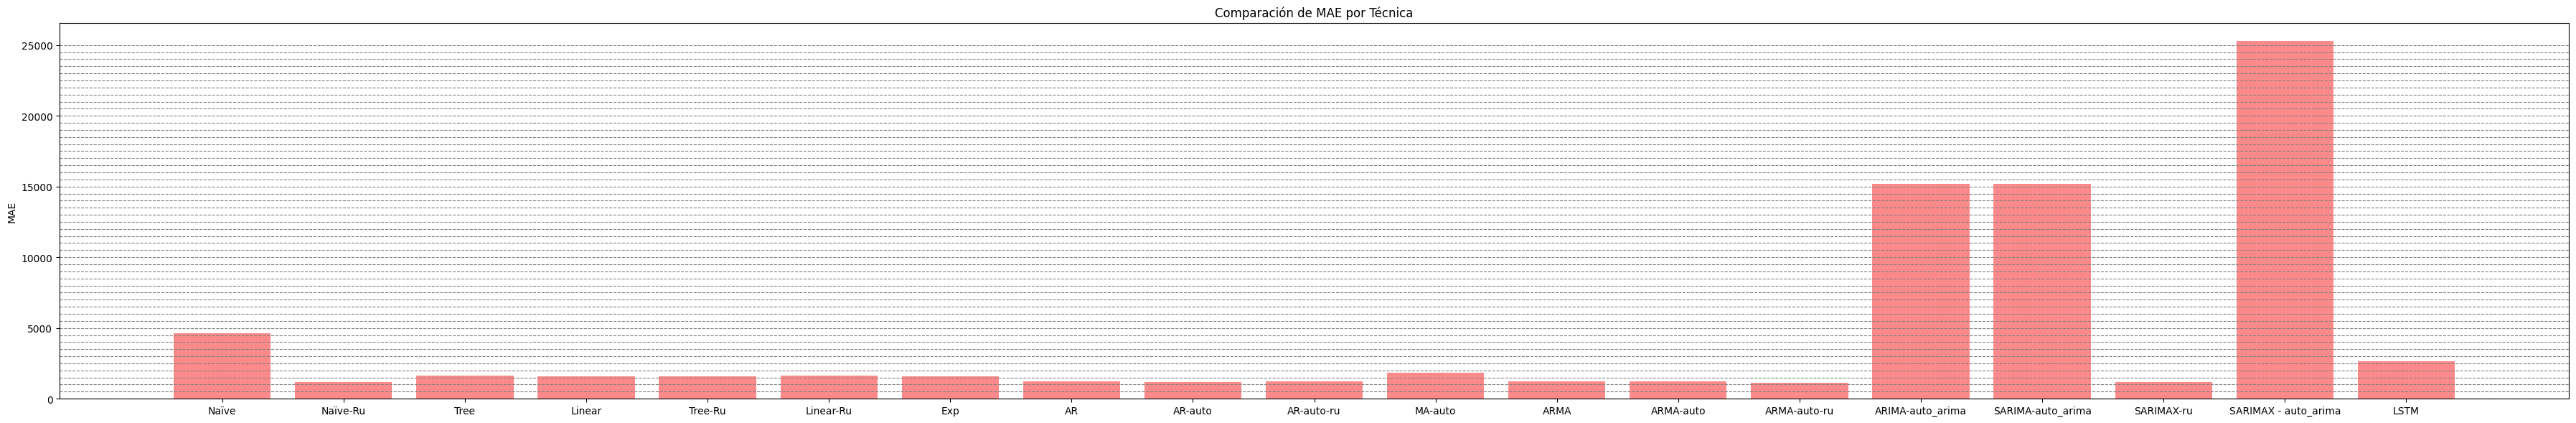

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(36,6))

axs.bar(tecnicas, MAE)
axs.set_ylabel('MAE')
axs.set_title('Comparación de MAE por Técnica')

for i in range(0, int(np.round(max(MAE)/500)) * 500, 500):
    axs.axhline(i, color='gray', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

In [ ]:
indices_mejores_mae = sorted(range(len(MAE)), key=lambda i: MAE[i])[:3]
print(f'Los tres mejores modelos son:{[tecnicas[i] for i in indices_mejores_mae]} con MAE de {[MAE[i] for i in indices_mejores_mae]}, respectivamente.')

Los tres mejores modelos son:['ARMA-auto-ru', 'Naïve-Ru', 'SARIMAX-ru'] con MAE de [1148.8868223453007, 1165.3333333333333, 1171.5347864478456], respectivamente.


In [ ]:
print(f'Se ha conseguido un MAE de {min(MAE)}')

Se ha conseguido un MAE de 1148.8868223453007


# **4. Forecasting the year 2022**

In [ ]:
from pandas.tseries.offsets import DateOffset
X_full = df.groupby('fecha')['count'].sum().reset_index()
future_dates=pd.date_range(start=X_full['fecha'].max() + pd.DateOffset(months=1), periods=12, freq='MS')

In [ ]:
future_datest_df=pd.DataFrame(index=future_dates,columns=X_visualizacion.columns)

# Reset the index and move the dates to a 'fecha' column.
future_datest_df = future_datest_df.reset_index()
future_datest_df.rename(columns={'index': 'fecha'}, inplace=True)

print(future_datest_df)

        fecha count
0  2022-01-01   NaN
1  2022-02-01   NaN
2  2022-03-01   NaN
3  2022-04-01   NaN
4  2022-05-01   NaN
5  2022-06-01   NaN
6  2022-07-01   NaN
7  2022-08-01   NaN
8  2022-09-01   NaN
9  2022-10-01   NaN
10 2022-11-01   NaN
11 2022-12-01   NaN


In [ ]:
X_full = df.groupby('fecha')['count'].sum().reset_index()
future_df=pd.concat([X_full,future_datest_df]).reset_index()
future_df

,index,fecha,count
0,0,2016-01-01,34490
1,1,2016-02-01,32093
2,2,2016-03-01,34292
3,3,2016-04-01,31719
4,4,2016-05-01,33439
...,...,...,...
79,7,2022-08-01,NaN
80,8,2022-09-01,NaN
81,9,2022-10-01,NaN
82,10,2022-11-01,NaN


With our best previous models, we calculate the count values for the year 2022.

In [ ]:
last_time = future_df[future_df['fecha'].dt.year < 2022].index[-1] +1 # Index of the last sample of the year 2022

future_df = future_df['count']
X = future_df[0:last_time]
T_missing = range(last_time, future_df.shape[0])

future_df.fillna(0, inplace=True)

## **4.1 ARMA-auto w/ roll-up**

In [ ]:
X_hat_series = X
future_aux = future_df.copy()
for t in T_missing:
    series = X
    # print(f'Serie entrenada {future_aux[:t]}')
    model = ARIMA(future_aux[:t], order=(1,0,1))
    model_fit = model.fit()
    X_hat_series = np.hstack((X_hat_series, model_fit.predict(start=t,end=t,dynamic=True)))
    future_aux[t] = (model_fit.predict(start=t,end=t,dynamic=True))
    # print(f'Future Dataset actualizado: {future_aux[-12:]}')

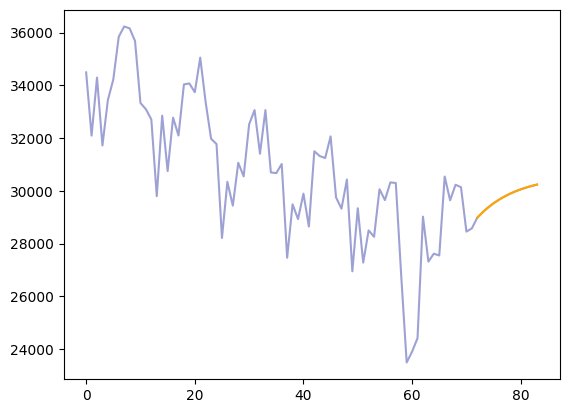

In [ ]:
plt.plot(future_aux, color='#9EA1D4')
# plt.plot(X, color='#FD8A8A')
plt.plot(T_missing, X_hat_series[T_missing], color='orange')
plt.show()

## **4.2 Naïve forecasting w/ roll-up**

In [ ]:
future_aux = future_df.copy()
def X_hat(X, t):
  X[t] = X[t-1]
  # print(X)
  return X[t-1]

X_hat_series = np.array([X_hat(future_aux, t) for t in T_missing])

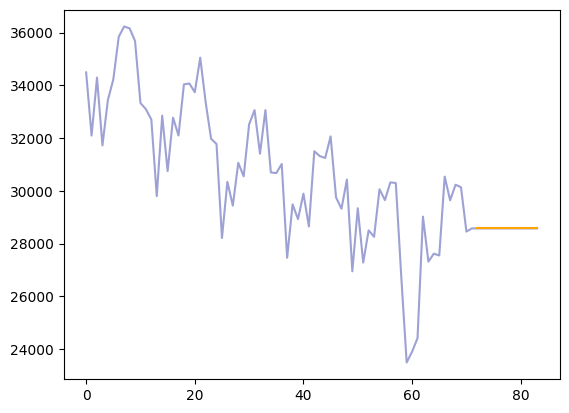

In [ ]:
plt.plot(future_aux, color='#9EA1D4')
# plt.plot(X, color='#FD8A8A')
plt.plot(T_missing, X_hat_series, color='orange')
plt.show()

## **4.3. SARIMAX w/ roll-up**

In [ ]:
X_hat_series = X
future_aux = future_df.copy()
for t in T_missing:
    series = X
    # The seasonal_order parameters of SARIMA are the same as for ARIMA
    # but the last one includes the period of the season.
    model = sm.tsa.statespace.SARIMAX(future_aux[:t], order=(1, 0, 0), seasonal_order=(0,0,0,12))
    # print(f'Serie entrenada: {future_aux[:t]}')
    model_fit = model.fit()
    X_hat_series = np.hstack((X_hat_series, model_fit.predict(start=t,end=t,dynamic=True)))
    future_aux[t] = (model_fit.predict(start=t,end=t,dynamic=True))
    # print(future_aux[-12:])

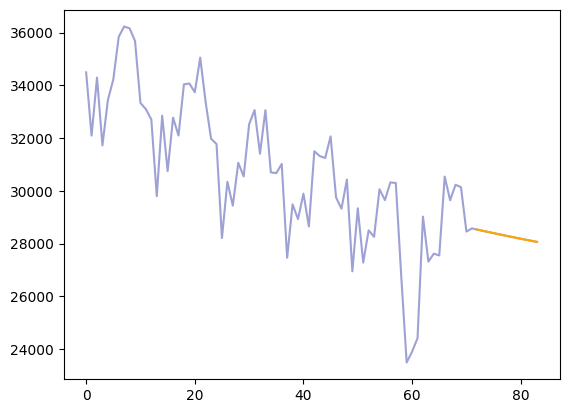

In [ ]:
plt.plot(future_aux, color='#9EA1D4')
# plt.plot(X, color='#FD8A8A')
plt.plot(T_missing, X_hat_series[T_missing], color='orange')
plt.show()



---

